In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
import os 
os.environ["CUDA_VISIBLE_DEVICES"]="0"
from cifar_model import generator,discriminator
from cifar_model import convnet as cnn

import utils

/home/data/bruno/anaconda3/envs/tf-1.4-env/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
'''
build unl data pipeline 
train gan cifar10 kinglsey
generate adv pert
train takeru or simple cnn cifar
get gains !
'''

'\nbuild unl data pipeline \ntrain gan cifar10 kinglsey\ngenerate adv pert\ntrain takeru or simple cnn cifar\nget gains !\n'

In [3]:
params = dict(
    batch_size = 50,
    seed = 1234,
    z_dim = 100,
    lr = 1e-4,
    logdir = 'cifar_gans/',
    name_model = 'model_kingsley'
)
rng = np.random.RandomState(params['seed'])  # seed labels

In [4]:
params_dnn = dict(
    batch=50,
    lr = 1e-4,
    labeled = 100,
    seed = 1234,
    epoch=801
)

In [5]:
def plot_dics(l):
    plt.figure(figsize=(15,5))
    plt.subplot(121)
    names=[]
    for var in ['train','test','ema']:
        for d in l:
            x=d.item().get(var)
            plt.plot(x)
            names.append(var + '_' + d.item().get('name'))
    plt.legend(names)
    plt.subplot(122)
    names=[]
    for var in ['loss','mani']:
        for d in l:
            x=d.item().get(var)
            plt.plot(x)
            names.append(var + '_' + d.item().get('name'))
            plt.legend(names)

## Data

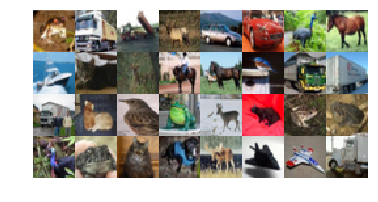

In [6]:
(trainx, trainy), (testx, testy) = tf.keras.datasets.cifar10.load_data()
def rescale(mat):
    return ((-127.5 + mat) / 127.5)
trainx = rescale(trainx)
testx = rescale(testx)
trainy = np.squeeze(trainy)
testy = np.squeeze(testy)
trainx_unl = trainx.copy()
nr_batch_unl = trainx_unl.shape[0] // params['batch_size']
utils.show_cifar(trainx_unl[:32])

train: (1000, 32, 32, 3) test: (10000, 32, 32, 3)


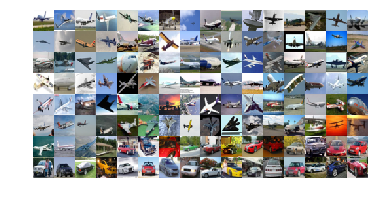

In [7]:
inds = rng.permutation(trainx.shape[0])
trainx = trainx[inds]
trainy = trainy[inds]
txs = []
tys = []
for j in range(10):
    txs.append(trainx[trainy == j][:params_dnn['labeled']])
    tys.append(trainy[trainy == j][:params_dnn['labeled']])
txs = np.concatenate(txs, axis=0)
tys = np.concatenate(tys, axis=0)
trainx = txs
trainy = tys
nr_batch_train = trainx.shape[0] // params_dnn['batch']
nr_batch_test = testx.shape[0] // params_dnn['batch']
print('train:',trainx.shape,'test:',testx.shape)
utils.show_cifar(trainx[:128])

## GAN training

In [8]:
unl = tf.placeholder(tf.float32, [params['batch_size'], 32,32,3])
is_training_pl = tf.placeholder(tf.bool, [], name='is_training_pl')
noise = tf.random_normal(shape=[params['batch_size'],params['z_dim']])

samples = generator(noise,is_training=is_training_pl,reuse=tf.AUTO_REUSE)
real_score = discriminator(unl,is_training=is_training_pl,reuse=tf.AUTO_REUSE)
fake_score = discriminator(samples,is_training=is_training_pl,reuse=tf.AUTO_REUSE)

gen_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "generator")
disc_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "discriminator") 

loss_g = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=fake_score,labels=tf.ones_like(fake_score)))
loss_d = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=real_score,labels=tf.ones_like(fake_score)))+\
tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=fake_score,labels=tf.zeros_like(fake_score)))

optimizer = tf.train.AdamOptimizer(learning_rate=params['lr'], beta1=0.5)

update_ops_gen = tf.get_collection(tf.GraphKeys.UPDATE_OPS, scope='generator')
update_ops_dis = tf.get_collection(tf.GraphKeys.UPDATE_OPS, scope='discriminator')

with tf.control_dependencies(update_ops_gen): # attached op for moving average batch norm
    traing = optimizer.minimize(loss_g,var_list=gen_vars)
with tf.control_dependencies(update_ops_dis):
    traind = optimizer.minimize(loss_d,var_list=disc_vars)

In [9]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

In [10]:
saver = tf.train.Saver()

In [11]:
path = './gan_cifar_saved/'
if tf.train.latest_checkpoint(path) is not None:
    path = saver.restore(sess, tf.train.latest_checkpoint(path))
else:
    print('no model found')

INFO:tensorflow:Restoring parameters from ./gan_cifar_saved/kingsley


In [12]:
# viz_every = 500
# for epoch in tqdm(range(10001)):
#     trainx_unl = trainx_unl[rng.permutation(trainx_unl.shape[0])]  # shuffling unl dataset   
    
#     for step in range(nr_batch_unl):
#         ran_from = step * params['batch_size']
#         ran_to = (step + 1) * params['batch_size']
#         sess.run(traind,{is_training_pl:True,unl:trainx_unl[ran_from:ran_to]})
#         sess.run(traing,{is_training_pl:True,unl:trainx_unl[ran_from:ran_to]})

#         if (step) % viz_every == 0:
#             xx, yy = sess.run([unl,samples],{is_training_pl:False,unl:trainx_unl[ran_from:ran_to]})
#             plt.figure(figsize=(15,5))
#             plt.subplot(121)
#             utils.show_cifar(xx[:32])
#             plt.subplot(122)
#             utils.show_cifar(yy[:32])
#             plt.show()


In [13]:
# saver.save(sess, './gan_cifar_saved/kingsley')

## Vizualization manifold examples

In [14]:
# ############ MANIFOLD ##########
z1 = tf.random_normal(shape=[params['batch_size'],params['z_dim']])
pert_n = tf.nn.l2_normalize(tf.random_normal(shape=[params['batch_size'],params['z_dim']]),dim=[1])
z1_pert = z1 + 1. * pert_n
pz = tf.random_normal([params['batch_size'],32,32,1],stddev=0.2) 

samp_z1 = generator(z1,is_training=is_training_pl,reuse=tf.AUTO_REUSE)
samp_z2 = generator(z1_pert,is_training=is_training_pl,reuse=tf.AUTO_REUSE)
samp_adv = samp_z1 + 5.* tf.nn.l2_normalize(samp_z2-samp_z1,dim=[1,2,3])


In [15]:
xx,yy = sess.run([samp_z1,samp_adv],{is_training_pl:False})
xx = (xx+1.)/2.
yy = (yy+1.)/2.
yy[yy>1.]=1
yy[yy<0]=0

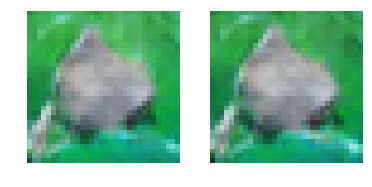

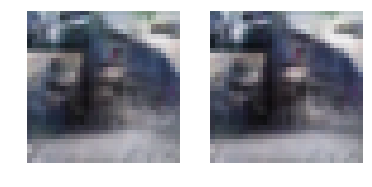

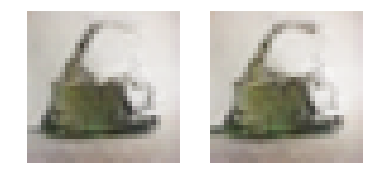

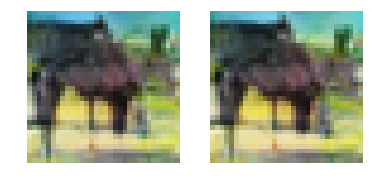

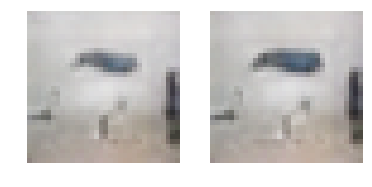

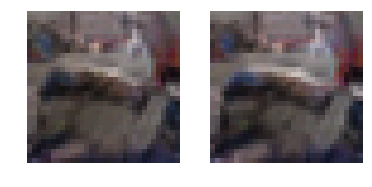

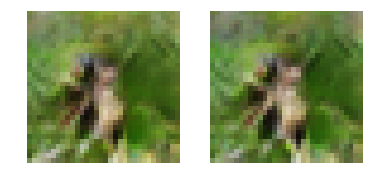

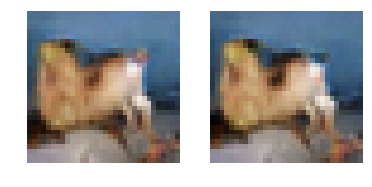

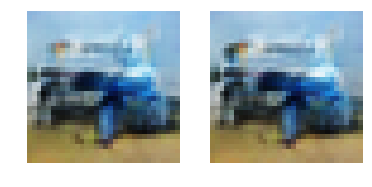

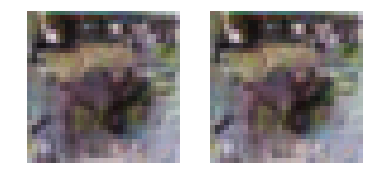

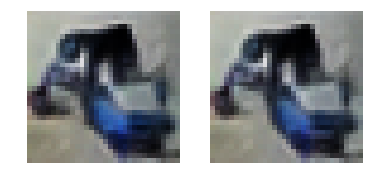

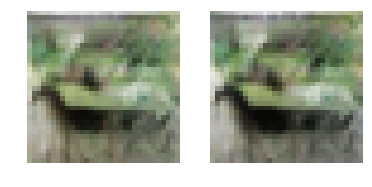

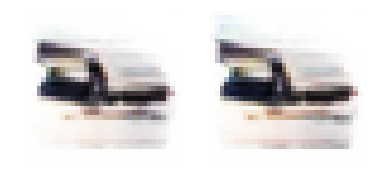

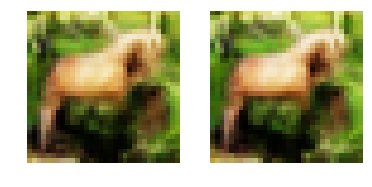

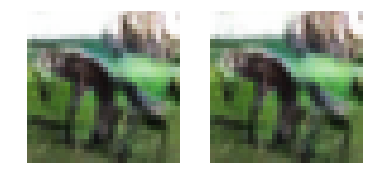

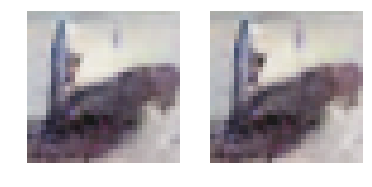

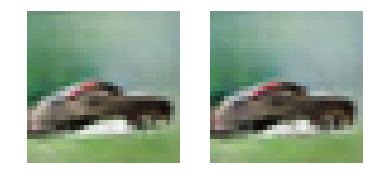

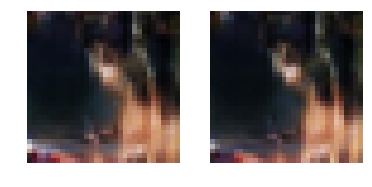

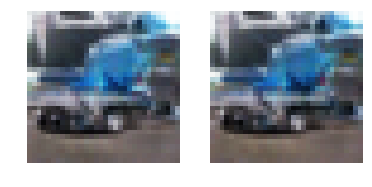

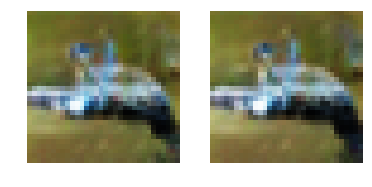

In [16]:
for idx in range(20):
    plt.subplot(1,2,1)
    plt.imshow(np.squeeze(xx[idx]))
    plt.axis('off')
    plt.subplot(1,2,2)
    plt.imshow(np.squeeze(yy[idx]))
    plt.axis('off')
    plt.show()

## Training CNN

In [17]:
inp = tf.placeholder(tf.float32, [params_dnn['batch'], 32,32,3])
lbl = tf.placeholder(tf.int64, [params_dnn['batch']])
# ma_decay = tf.placeholder(tf.float32,[],name='ma_decay_pl')
training_cnn  = tf.placeholder(tf.bool,[])
logits = cnn(inp,training_cnn)
xloss = tf.losses.sparse_softmax_cross_entropy(logits=logits,labels=lbl)

In [18]:
logits_z1= cnn(samp_z1,training_cnn)
logits_z2 = cnn(samp_z2+pz,training_cnn)
logits_adv = cnn(samp_adv,training_cnn) # ADD PZ 

manifold = tf.reduce_sum(tf.sqrt(tf.square(logits_z1-logits_adv)+1e-8),axis=1)
manifold_loss = tf.reduce_mean(manifold)

In [19]:
loss = xloss + 0.005 * manifold_loss

In [20]:
with tf.variable_scope("adam",reuse=tf.AUTO_REUSE):
    global_step = tf.Variable(0, name='global_step',trainable=False)
    optimizer = tf.train.AdamOptimizer(learning_rate=params_dnn['lr'])
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS,scope='classifier')  # control dependencies for batch norm ops
    with tf.control_dependencies(update_ops):
        train_op = optimizer.minimize(loss,var_list=tf.trainable_variables(scope='classifier'),global_step=global_step)
        
correct_prediction = tf.equal(tf.argmax(logits,1),lbl)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [21]:
ema = tf.train.ExponentialMovingAverage(decay=0.995)
dvars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,scope='classifier')
maintain_averages_op = ema.apply(dvars)

with tf.control_dependencies([train_op]):
    train_op = tf.group(maintain_averages_op)

def ema_getter(getter, name, *args, **kwargs):
    var = getter(name, *args, **kwargs)
    ema_var = ema.average(var)
    return ema_var if ema_var else var 
    
logits_ema = cnn(inp, training_cnn, getter=ema_getter)
correct_prediction_ema = tf.equal(tf.argmax(logits_ema,1),lbl)
accuracy_ema = tf.reduce_mean(tf.cast(correct_prediction_ema, tf.float32))

In [22]:
#init
var = tf.global_variables(scope='classifier')+tf.global_variables(scope='adam')
init_op = tf.variables_initializer(var_list=var)

In [23]:
sess.run(init_op)
name_experiment = './100lbl_cifar/conv_large_g0.005_e5_eta1_ema995.npy'
train_array = [];test_array=[]; loss_array=[]; manifold_array=[];test_array_ema=[]

Epoch: 0,global_stp: 20, xloss: 2.17158, maniloss: 1.58203, train: 16.90%, test: 10.56,test_ma: 10.00%


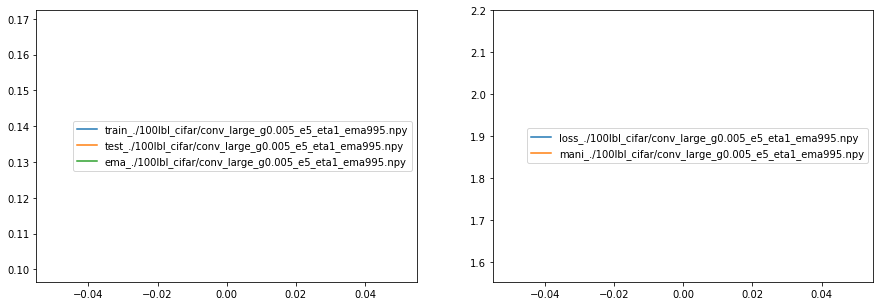

Epoch: 1,global_stp: 40, xloss: 1.91127, maniloss: 1.82541, train: 28.10%, test: 11.93,test_ma: 10.01%
Epoch: 2,global_stp: 60, xloss: 1.78767, maniloss: 1.93272, train: 34.50%, test: 10.51,test_ma: 10.02%
Epoch: 3,global_stp: 80, xloss: 1.69469, maniloss: 2.06128, train: 37.50%, test: 12.09,test_ma: 10.00%
Epoch: 4,global_stp: 100, xloss: 1.63688, maniloss: 2.21714, train: 40.30%, test: 13.90,test_ma: 10.00%
Epoch: 5,global_stp: 120, xloss: 1.57411, maniloss: 2.27265, train: 44.00%, test: 16.39,test_ma: 10.00%
Epoch: 6,global_stp: 140, xloss: 1.51630, maniloss: 2.35511, train: 46.70%, test: 22.33,test_ma: 10.00%
Epoch: 7,global_stp: 160, xloss: 1.46438, maniloss: 2.49501, train: 48.60%, test: 24.09,test_ma: 10.03%
Epoch: 8,global_stp: 180, xloss: 1.43837, maniloss: 2.53929, train: 50.40%, test: 26.86,test_ma: 10.03%
Epoch: 9,global_stp: 200, xloss: 1.37841, maniloss: 2.58418, train: 52.00%, test: 27.81,test_ma: 10.21%
Epoch: 10,global_stp: 220, xloss: 1.32131, maniloss: 2.77023, train

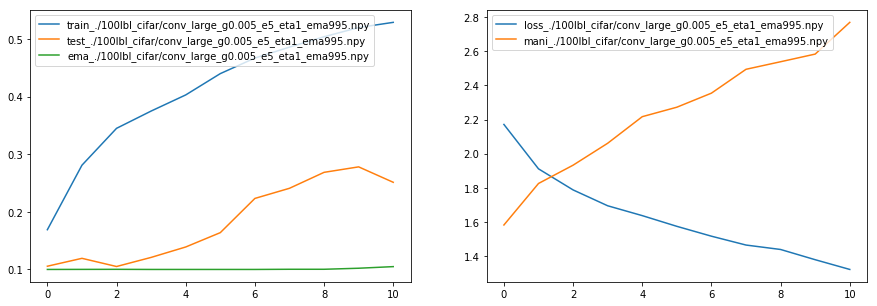

Epoch: 11,global_stp: 240, xloss: 1.29304, maniloss: 2.86932, train: 55.50%, test: 28.28,test_ma: 11.24%
Epoch: 12,global_stp: 260, xloss: 1.23697, maniloss: 2.94234, train: 58.40%, test: 33.36,test_ma: 11.44%
Epoch: 13,global_stp: 280, xloss: 1.20638, maniloss: 3.02374, train: 58.30%, test: 31.08,test_ma: 12.00%
Epoch: 14,global_stp: 300, xloss: 1.18100, maniloss: 3.04150, train: 62.10%, test: 32.59,test_ma: 12.92%
Epoch: 15,global_stp: 320, xloss: 1.14592, maniloss: 3.08722, train: 60.70%, test: 31.37,test_ma: 13.41%
Epoch: 16,global_stp: 340, xloss: 1.09593, maniloss: 3.19330, train: 63.40%, test: 31.89,test_ma: 14.69%
Epoch: 17,global_stp: 360, xloss: 1.06177, maniloss: 3.35273, train: 65.20%, test: 33.05,test_ma: 15.91%
Epoch: 18,global_stp: 380, xloss: 1.05277, maniloss: 3.38411, train: 65.00%, test: 36.46,test_ma: 17.90%
Epoch: 19,global_stp: 400, xloss: 1.01286, maniloss: 3.49582, train: 65.70%, test: 30.06,test_ma: 17.69%
Epoch: 20,global_stp: 420, xloss: 0.99741, maniloss: 3.

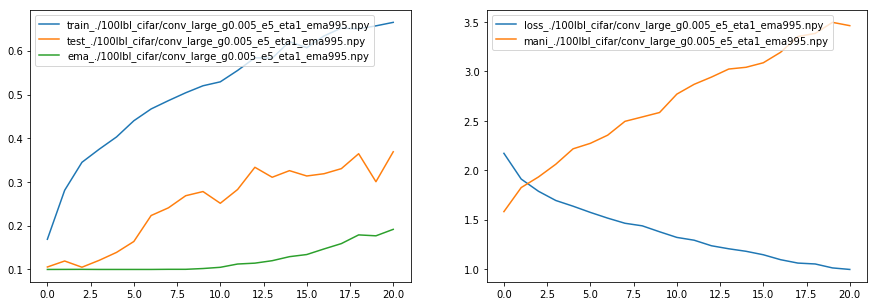

Epoch: 21,global_stp: 440, xloss: 0.95143, maniloss: 3.49810, train: 68.90%, test: 37.03,test_ma: 18.86%
Epoch: 22,global_stp: 460, xloss: 0.96390, maniloss: 3.71522, train: 69.00%, test: 31.97,test_ma: 20.10%
Epoch: 23,global_stp: 480, xloss: 0.92945, maniloss: 3.64443, train: 69.30%, test: 31.44,test_ma: 20.16%
Epoch: 24,global_stp: 500, xloss: 0.87764, maniloss: 3.78857, train: 73.70%, test: 37.66,test_ma: 21.03%
Epoch: 25,global_stp: 520, xloss: 0.84929, maniloss: 3.90750, train: 74.60%, test: 32.24,test_ma: 21.75%
Epoch: 26,global_stp: 540, xloss: 0.81459, maniloss: 3.91024, train: 73.50%, test: 33.57,test_ma: 22.13%
Epoch: 27,global_stp: 560, xloss: 0.80222, maniloss: 3.99769, train: 74.40%, test: 30.24,test_ma: 22.91%
Epoch: 28,global_stp: 580, xloss: 0.76432, maniloss: 4.06149, train: 78.20%, test: 39.37,test_ma: 23.96%
Epoch: 29,global_stp: 600, xloss: 0.78101, maniloss: 4.06677, train: 75.40%, test: 33.56,test_ma: 24.63%
Epoch: 30,global_stp: 620, xloss: 0.74843, maniloss: 4.

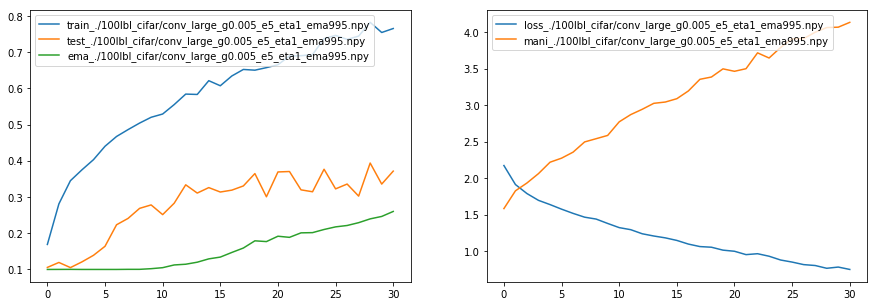

Epoch: 31,global_stp: 640, xloss: 0.68726, maniloss: 4.20280, train: 80.50%, test: 35.04,test_ma: 26.06%
Epoch: 32,global_stp: 660, xloss: 0.67842, maniloss: 4.26745, train: 79.80%, test: 37.59,test_ma: 27.60%
Epoch: 33,global_stp: 680, xloss: 0.69900, maniloss: 4.26345, train: 80.10%, test: 38.93,test_ma: 28.42%
Epoch: 34,global_stp: 700, xloss: 0.64259, maniloss: 4.47604, train: 82.00%, test: 36.82,test_ma: 29.26%
Epoch: 35,global_stp: 720, xloss: 0.62579, maniloss: 4.45937, train: 81.20%, test: 37.57,test_ma: 29.32%
Epoch: 36,global_stp: 740, xloss: 0.61887, maniloss: 4.61798, train: 81.50%, test: 37.62,test_ma: 31.84%
Epoch: 37,global_stp: 760, xloss: 0.56800, maniloss: 4.72363, train: 84.70%, test: 37.51,test_ma: 34.81%
Epoch: 38,global_stp: 780, xloss: 0.59426, maniloss: 4.67894, train: 83.10%, test: 37.91,test_ma: 35.50%
Epoch: 39,global_stp: 800, xloss: 0.54203, maniloss: 4.78375, train: 84.80%, test: 41.54,test_ma: 36.16%
Epoch: 40,global_stp: 820, xloss: 0.50809, maniloss: 4.

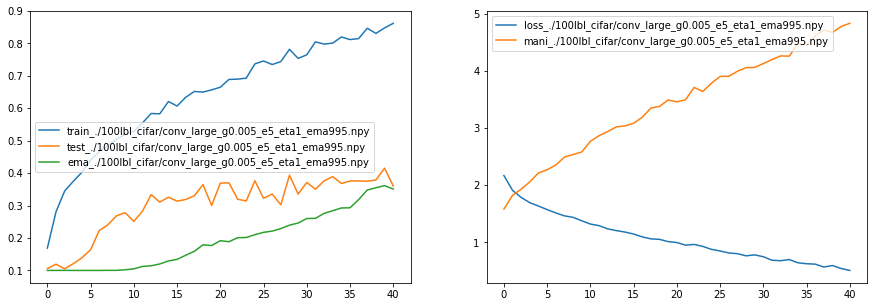

Epoch: 41,global_stp: 840, xloss: 0.49330, maniloss: 4.96406, train: 87.00%, test: 38.98,test_ma: 33.46%
Epoch: 42,global_stp: 860, xloss: 0.47478, maniloss: 4.96730, train: 87.40%, test: 37.66,test_ma: 34.28%
Epoch: 43,global_stp: 880, xloss: 0.46429, maniloss: 4.90445, train: 87.00%, test: 33.69,test_ma: 31.71%
Epoch: 44,global_stp: 900, xloss: 0.49966, maniloss: 5.08084, train: 85.70%, test: 39.41,test_ma: 36.10%
Epoch: 45,global_stp: 920, xloss: 0.46719, maniloss: 5.07273, train: 86.70%, test: 35.46,test_ma: 35.37%
Epoch: 46,global_stp: 940, xloss: 0.42008, maniloss: 5.13344, train: 88.90%, test: 39.44,test_ma: 38.40%
Epoch: 47,global_stp: 960, xloss: 0.40620, maniloss: 5.13358, train: 89.50%, test: 44.20,test_ma: 38.60%
Epoch: 48,global_stp: 980, xloss: 0.40560, maniloss: 5.36144, train: 89.30%, test: 39.14,test_ma: 38.22%
Epoch: 49,global_stp: 1000, xloss: 0.37797, maniloss: 5.32362, train: 90.10%, test: 39.82,test_ma: 39.45%
Epoch: 50,global_stp: 1020, xloss: 0.36496, maniloss: 

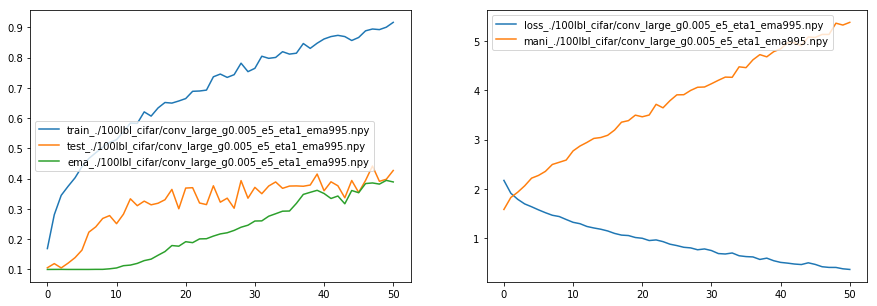

Epoch: 51,global_stp: 1040, xloss: 0.35105, maniloss: 5.32905, train: 91.90%, test: 38.22,test_ma: 41.47%
Epoch: 52,global_stp: 1060, xloss: 0.34914, maniloss: 5.30197, train: 91.60%, test: 39.33,test_ma: 40.39%
Epoch: 53,global_stp: 1080, xloss: 0.30900, maniloss: 5.56726, train: 92.90%, test: 39.16,test_ma: 41.78%
Epoch: 54,global_stp: 1100, xloss: 0.32043, maniloss: 5.51861, train: 92.80%, test: 36.79,test_ma: 42.08%
Epoch: 55,global_stp: 1120, xloss: 0.32147, maniloss: 5.61023, train: 92.80%, test: 44.27,test_ma: 41.55%
Epoch: 56,global_stp: 1140, xloss: 0.29954, maniloss: 5.64313, train: 94.00%, test: 40.32,test_ma: 42.75%
Epoch: 57,global_stp: 1160, xloss: 0.28042, maniloss: 5.53322, train: 94.30%, test: 44.00,test_ma: 40.67%
Epoch: 58,global_stp: 1180, xloss: 0.28533, maniloss: 5.66822, train: 92.80%, test: 42.46,test_ma: 41.53%
Epoch: 59,global_stp: 1200, xloss: 0.25489, maniloss: 5.74719, train: 94.60%, test: 40.44,test_ma: 42.99%
Epoch: 60,global_stp: 1220, xloss: 0.24929, ma

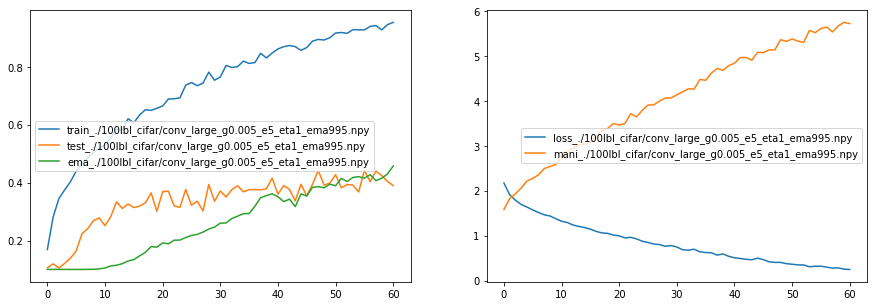

Epoch: 61,global_stp: 1240, xloss: 0.27850, maniloss: 5.93194, train: 92.60%, test: 42.04,test_ma: 46.68%
Epoch: 62,global_stp: 1260, xloss: 0.24430, maniloss: 5.79449, train: 94.90%, test: 45.34,test_ma: 44.74%
Epoch: 63,global_stp: 1280, xloss: 0.25633, maniloss: 5.86507, train: 94.40%, test: 47.03,test_ma: 44.91%
Epoch: 64,global_stp: 1300, xloss: 0.22891, maniloss: 6.05506, train: 95.40%, test: 46.72,test_ma: 41.44%
Epoch: 65,global_stp: 1320, xloss: 0.19853, maniloss: 5.97422, train: 97.00%, test: 43.38,test_ma: 42.96%
Epoch: 66,global_stp: 1340, xloss: 0.18930, maniloss: 6.18034, train: 97.40%, test: 44.34,test_ma: 42.20%
Epoch: 67,global_stp: 1360, xloss: 0.18244, maniloss: 6.14565, train: 97.10%, test: 43.98,test_ma: 41.85%
Epoch: 68,global_stp: 1380, xloss: 0.21044, maniloss: 6.05828, train: 95.90%, test: 43.22,test_ma: 42.70%
Epoch: 69,global_stp: 1400, xloss: 0.19652, maniloss: 6.13417, train: 96.40%, test: 40.14,test_ma: 42.50%
Epoch: 70,global_stp: 1420, xloss: 0.15645, ma

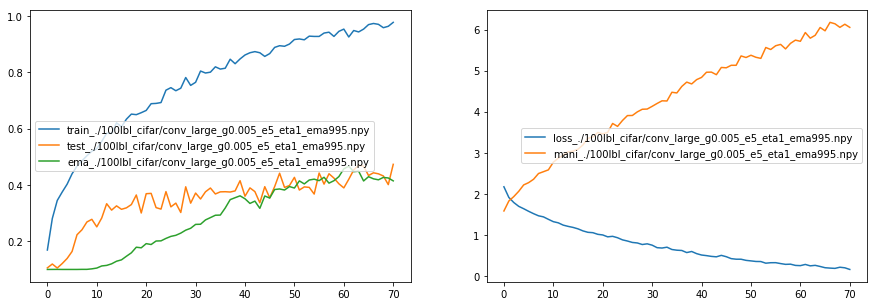

Epoch: 71,global_stp: 1440, xloss: 0.17626, maniloss: 6.12665, train: 96.80%, test: 47.30,test_ma: 42.34%
Epoch: 72,global_stp: 1460, xloss: 0.17066, maniloss: 6.19282, train: 96.60%, test: 42.93,test_ma: 43.00%
Epoch: 73,global_stp: 1480, xloss: 0.15066, maniloss: 6.24389, train: 97.90%, test: 45.77,test_ma: 45.18%
Epoch: 74,global_stp: 1500, xloss: 0.16529, maniloss: 6.04205, train: 97.00%, test: 44.26,test_ma: 42.65%
Epoch: 75,global_stp: 1520, xloss: 0.15605, maniloss: 6.26434, train: 97.50%, test: 44.49,test_ma: 43.88%
Epoch: 76,global_stp: 1540, xloss: 0.13608, maniloss: 6.23102, train: 98.00%, test: 45.31,test_ma: 45.97%
Epoch: 77,global_stp: 1560, xloss: 0.14666, maniloss: 6.26493, train: 97.60%, test: 45.53,test_ma: 46.22%
Epoch: 78,global_stp: 1580, xloss: 0.14676, maniloss: 6.19954, train: 96.80%, test: 46.45,test_ma: 47.05%
Epoch: 79,global_stp: 1600, xloss: 0.12706, maniloss: 6.32422, train: 98.10%, test: 44.52,test_ma: 46.25%
Epoch: 80,global_stp: 1620, xloss: 0.13937, ma

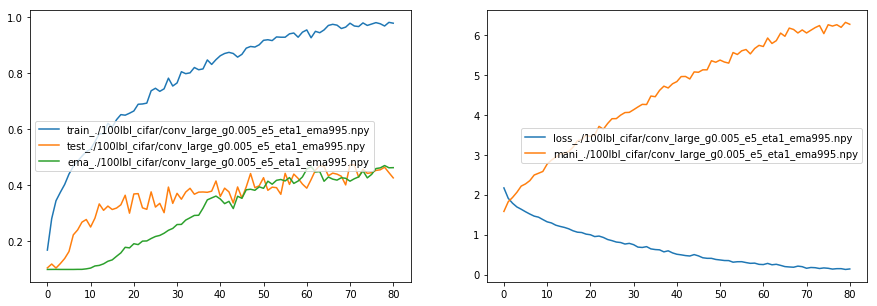

Epoch: 81,global_stp: 1640, xloss: 0.13755, maniloss: 6.31888, train: 98.00%, test: 46.28,test_ma: 45.62%
Epoch: 82,global_stp: 1660, xloss: 0.13977, maniloss: 6.22463, train: 97.50%, test: 42.56,test_ma: 44.46%
Epoch: 83,global_stp: 1680, xloss: 0.12940, maniloss: 6.41327, train: 98.20%, test: 41.27,test_ma: 46.84%
Epoch: 84,global_stp: 1700, xloss: 0.12761, maniloss: 6.31669, train: 97.70%, test: 44.76,test_ma: 48.60%
Epoch: 85,global_stp: 1720, xloss: 0.11433, maniloss: 6.49414, train: 98.60%, test: 46.06,test_ma: 47.57%
Epoch: 86,global_stp: 1740, xloss: 0.12914, maniloss: 6.47274, train: 98.30%, test: 41.54,test_ma: 47.49%
Epoch: 87,global_stp: 1760, xloss: 0.11859, maniloss: 6.37184, train: 98.60%, test: 47.22,test_ma: 47.41%
Epoch: 88,global_stp: 1780, xloss: 0.09452, maniloss: 6.42340, train: 99.30%, test: 46.84,test_ma: 48.14%
Epoch: 89,global_stp: 1800, xloss: 0.10683, maniloss: 6.61112, train: 98.50%, test: 45.23,test_ma: 48.74%
Epoch: 90,global_stp: 1820, xloss: 0.10743, ma

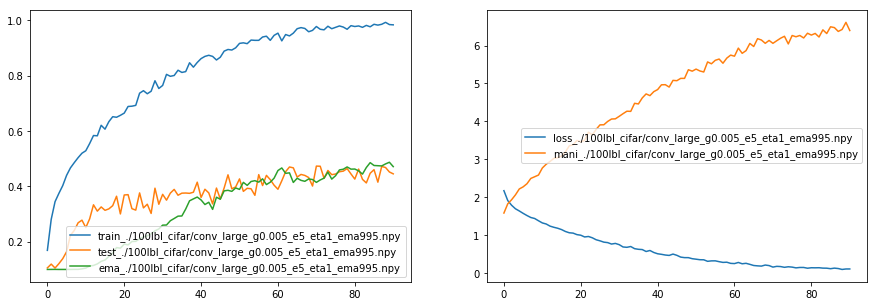

Epoch: 91,global_stp: 1840, xloss: 0.09850, maniloss: 6.64717, train: 99.10%, test: 43.39,test_ma: 47.44%
Epoch: 92,global_stp: 1860, xloss: 0.08415, maniloss: 6.69433, train: 99.10%, test: 40.02,test_ma: 48.73%
Epoch: 93,global_stp: 1880, xloss: 0.10476, maniloss: 6.56590, train: 98.20%, test: 46.59,test_ma: 49.71%
Epoch: 94,global_stp: 1900, xloss: 0.10531, maniloss: 6.68584, train: 98.40%, test: 45.70,test_ma: 48.62%
Epoch: 95,global_stp: 1920, xloss: 0.09944, maniloss: 6.48187, train: 98.40%, test: 46.68,test_ma: 47.65%
Epoch: 96,global_stp: 1940, xloss: 0.10521, maniloss: 6.56005, train: 98.50%, test: 48.94,test_ma: 48.68%
Epoch: 97,global_stp: 1960, xloss: 0.09473, maniloss: 6.60430, train: 98.50%, test: 47.25,test_ma: 48.66%
Epoch: 98,global_stp: 1980, xloss: 0.10000, maniloss: 6.74209, train: 98.70%, test: 46.33,test_ma: 49.20%
Epoch: 99,global_stp: 2000, xloss: 0.09862, maniloss: 6.60220, train: 98.70%, test: 44.99,test_ma: 49.20%
Epoch: 100,global_stp: 2020, xloss: 0.08592, m

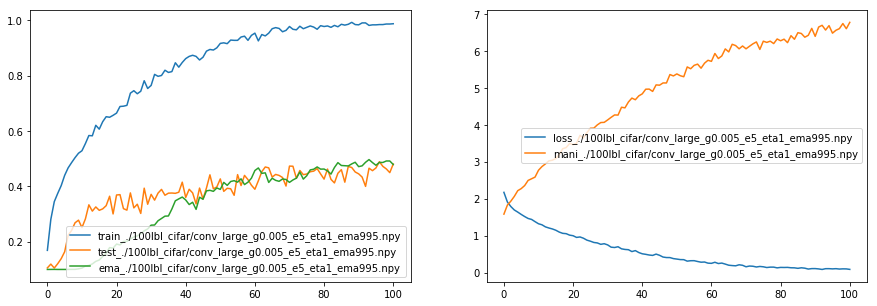

Epoch: 101,global_stp: 2040, xloss: 0.08286, maniloss: 6.69722, train: 99.10%, test: 44.32,test_ma: 49.79%
Epoch: 102,global_stp: 2060, xloss: 0.11027, maniloss: 6.59048, train: 97.70%, test: 43.29,test_ma: 49.67%
Epoch: 103,global_stp: 2080, xloss: 0.09827, maniloss: 6.52789, train: 98.20%, test: 48.61,test_ma: 49.43%
Epoch: 104,global_stp: 2100, xloss: 0.11045, maniloss: 6.57285, train: 97.90%, test: 45.33,test_ma: 47.59%
Epoch: 105,global_stp: 2120, xloss: 0.09030, maniloss: 6.56190, train: 98.40%, test: 45.32,test_ma: 46.87%
Epoch: 106,global_stp: 2140, xloss: 0.08707, maniloss: 6.59097, train: 98.50%, test: 46.61,test_ma: 45.98%
Epoch: 107,global_stp: 2160, xloss: 0.07031, maniloss: 6.65952, train: 99.10%, test: 45.10,test_ma: 46.10%
Epoch: 108,global_stp: 2180, xloss: 0.06711, maniloss: 6.67699, train: 99.50%, test: 45.61,test_ma: 48.77%
Epoch: 109,global_stp: 2200, xloss: 0.06263, maniloss: 6.62593, train: 99.20%, test: 49.25,test_ma: 49.63%
Epoch: 110,global_stp: 2220, xloss: 0

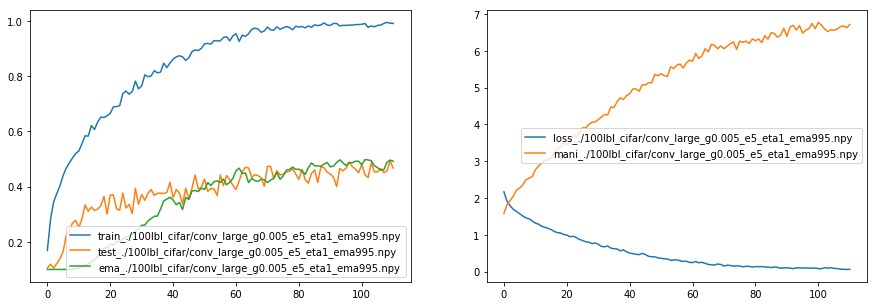

Epoch: 111,global_stp: 2240, xloss: 0.07049, maniloss: 6.79400, train: 99.00%, test: 49.43,test_ma: 48.96%
Epoch: 112,global_stp: 2260, xloss: 0.06730, maniloss: 6.88319, train: 99.00%, test: 50.83,test_ma: 48.40%
Epoch: 113,global_stp: 2280, xloss: 0.05907, maniloss: 6.77341, train: 99.50%, test: 46.17,test_ma: 48.80%
Epoch: 114,global_stp: 2300, xloss: 0.05785, maniloss: 6.59193, train: 99.10%, test: 46.78,test_ma: 49.76%
Epoch: 115,global_stp: 2320, xloss: 0.05027, maniloss: 6.66752, train: 99.70%, test: 48.21,test_ma: 50.10%
Epoch: 116,global_stp: 2340, xloss: 0.05192, maniloss: 6.83160, train: 99.50%, test: 48.06,test_ma: 50.17%
Epoch: 117,global_stp: 2360, xloss: 0.04948, maniloss: 6.76603, train: 99.80%, test: 48.68,test_ma: 50.18%
Epoch: 118,global_stp: 2380, xloss: 0.05067, maniloss: 6.86342, train: 99.90%, test: 48.61,test_ma: 50.30%
Epoch: 119,global_stp: 2400, xloss: 0.03605, maniloss: 6.82721, train: 99.80%, test: 48.17,test_ma: 50.74%
Epoch: 120,global_stp: 2420, xloss: 0

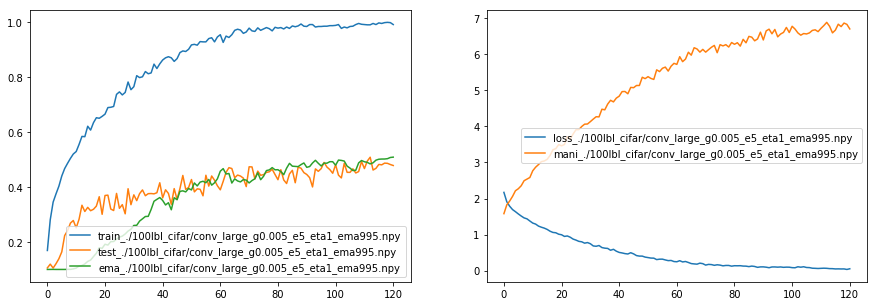

Epoch: 121,global_stp: 2440, xloss: 0.05359, maniloss: 6.93564, train: 99.50%, test: 46.83,test_ma: 51.53%
Epoch: 122,global_stp: 2460, xloss: 0.05367, maniloss: 6.83267, train: 99.60%, test: 48.98,test_ma: 51.28%
Epoch: 123,global_stp: 2480, xloss: 0.05766, maniloss: 6.80958, train: 98.90%, test: 50.08,test_ma: 51.52%
Epoch: 124,global_stp: 2500, xloss: 0.04737, maniloss: 6.76611, train: 99.60%, test: 48.00,test_ma: 50.66%
Epoch: 125,global_stp: 2520, xloss: 0.04852, maniloss: 6.82235, train: 99.50%, test: 46.61,test_ma: 50.76%
Epoch: 126,global_stp: 2540, xloss: 0.04120, maniloss: 6.85750, train: 99.40%, test: 49.39,test_ma: 50.83%
Epoch: 127,global_stp: 2560, xloss: 0.05329, maniloss: 6.80935, train: 99.50%, test: 49.67,test_ma: 50.43%
Epoch: 128,global_stp: 2580, xloss: 0.04994, maniloss: 6.85953, train: 99.20%, test: 50.34,test_ma: 51.64%
Epoch: 129,global_stp: 2600, xloss: 0.07159, maniloss: 6.72680, train: 98.20%, test: 46.61,test_ma: 49.89%
Epoch: 130,global_stp: 2620, xloss: 0

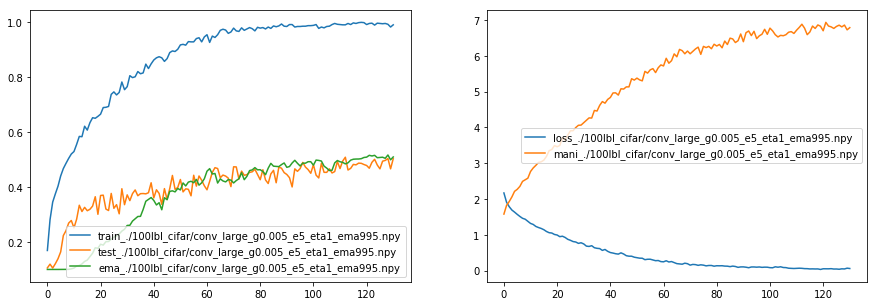

Epoch: 131,global_stp: 2640, xloss: 0.04668, maniloss: 6.82901, train: 99.40%, test: 45.20,test_ma: 51.93%
Epoch: 132,global_stp: 2660, xloss: 0.05668, maniloss: 6.80931, train: 99.10%, test: 52.49,test_ma: 51.24%
Epoch: 133,global_stp: 2680, xloss: 0.05354, maniloss: 6.79591, train: 99.60%, test: 48.66,test_ma: 50.18%
Epoch: 134,global_stp: 2700, xloss: 0.04513, maniloss: 6.85178, train: 99.30%, test: 46.50,test_ma: 51.18%
Epoch: 135,global_stp: 2720, xloss: 0.04729, maniloss: 6.94342, train: 99.40%, test: 50.61,test_ma: 51.29%
Epoch: 136,global_stp: 2740, xloss: 0.04616, maniloss: 6.69279, train: 99.60%, test: 50.26,test_ma: 51.82%
Epoch: 137,global_stp: 2760, xloss: 0.05636, maniloss: 6.90122, train: 99.20%, test: 44.79,test_ma: 50.23%
Epoch: 138,global_stp: 2780, xloss: 0.07987, maniloss: 6.66901, train: 98.40%, test: 48.49,test_ma: 48.51%
Epoch: 139,global_stp: 2800, xloss: 0.05499, maniloss: 6.69259, train: 99.40%, test: 49.82,test_ma: 50.43%
Epoch: 140,global_stp: 2820, xloss: 0

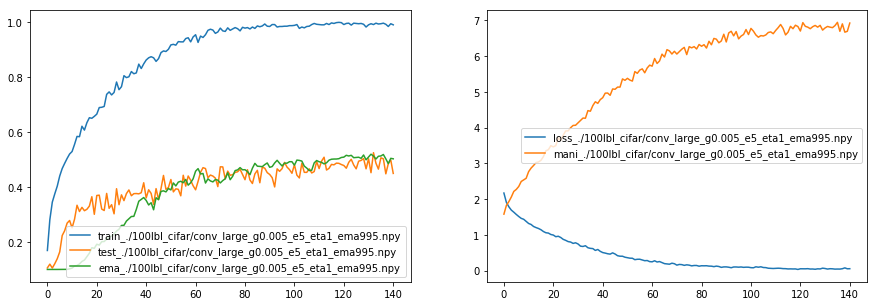

Epoch: 141,global_stp: 2840, xloss: 0.05123, maniloss: 6.95800, train: 99.40%, test: 44.53,test_ma: 53.03%
Epoch: 142,global_stp: 2860, xloss: 0.05888, maniloss: 6.83114, train: 99.00%, test: 48.81,test_ma: 52.97%
Epoch: 143,global_stp: 2880, xloss: 0.05123, maniloss: 6.75563, train: 99.20%, test: 50.82,test_ma: 52.39%
Epoch: 144,global_stp: 2900, xloss: 0.04417, maniloss: 6.66550, train: 99.40%, test: 43.37,test_ma: 49.93%
Epoch: 145,global_stp: 2920, xloss: 0.03986, maniloss: 6.85463, train: 99.60%, test: 50.67,test_ma: 51.04%
Epoch: 146,global_stp: 2940, xloss: 0.04658, maniloss: 6.83125, train: 99.00%, test: 45.86,test_ma: 49.85%
Epoch: 147,global_stp: 2960, xloss: 0.04475, maniloss: 6.77223, train: 99.70%, test: 48.29,test_ma: 50.12%
Epoch: 148,global_stp: 2980, xloss: 0.04113, maniloss: 6.90503, train: 99.70%, test: 48.45,test_ma: 49.99%
Epoch: 149,global_stp: 3000, xloss: 0.03037, maniloss: 6.81782, train: 100.00%, test: 51.86,test_ma: 49.17%
Epoch: 150,global_stp: 3020, xloss: 

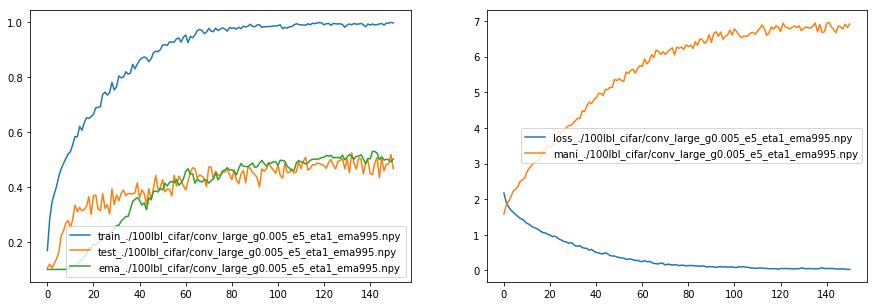

Epoch: 151,global_stp: 3040, xloss: 0.03301, maniloss: 6.99399, train: 99.50%, test: 50.99,test_ma: 52.41%
Epoch: 152,global_stp: 3060, xloss: 0.03920, maniloss: 6.88532, train: 99.50%, test: 48.81,test_ma: 51.46%
Epoch: 153,global_stp: 3080, xloss: 0.03323, maniloss: 6.87717, train: 99.90%, test: 50.13,test_ma: 52.26%
Epoch: 154,global_stp: 3100, xloss: 0.03869, maniloss: 6.76076, train: 99.60%, test: 50.23,test_ma: 51.56%
Epoch: 155,global_stp: 3120, xloss: 0.03899, maniloss: 6.93420, train: 99.30%, test: 50.99,test_ma: 52.42%
Epoch: 156,global_stp: 3140, xloss: 0.04842, maniloss: 6.71578, train: 99.30%, test: 51.07,test_ma: 51.04%
Epoch: 157,global_stp: 3160, xloss: 0.03918, maniloss: 6.90983, train: 99.30%, test: 50.65,test_ma: 50.50%
Epoch: 158,global_stp: 3180, xloss: 0.03288, maniloss: 6.88757, train: 99.60%, test: 49.42,test_ma: 49.04%
Epoch: 159,global_stp: 3200, xloss: 0.02653, maniloss: 6.75918, train: 99.80%, test: 52.17,test_ma: 49.96%
Epoch: 160,global_stp: 3220, xloss: 0

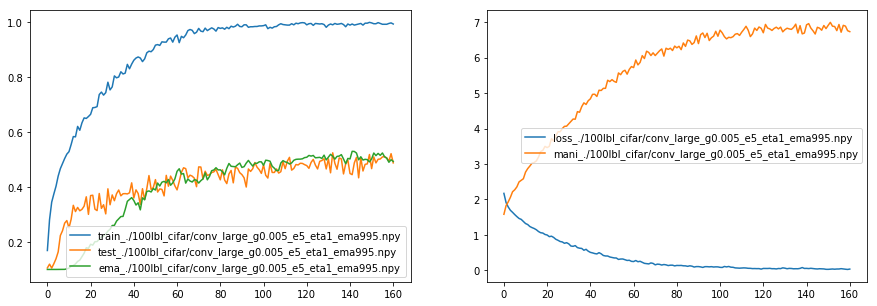

Epoch: 161,global_stp: 3240, xloss: 0.03317, maniloss: 6.84959, train: 99.80%, test: 50.24,test_ma: 49.74%
Epoch: 162,global_stp: 3260, xloss: 0.02633, maniloss: 6.89873, train: 99.70%, test: 50.13,test_ma: 50.41%
Epoch: 163,global_stp: 3280, xloss: 0.02862, maniloss: 6.90325, train: 99.90%, test: 50.42,test_ma: 51.26%
Epoch: 164,global_stp: 3300, xloss: 0.01909, maniloss: 7.03627, train: 100.00%, test: 51.69,test_ma: 50.09%
Epoch: 165,global_stp: 3320, xloss: 0.02034, maniloss: 6.80749, train: 99.80%, test: 51.14,test_ma: 50.30%
Epoch: 166,global_stp: 3340, xloss: 0.02507, maniloss: 6.83955, train: 99.90%, test: 50.22,test_ma: 51.23%
Epoch: 167,global_stp: 3360, xloss: 0.02303, maniloss: 6.89656, train: 100.00%, test: 50.95,test_ma: 50.05%
Epoch: 168,global_stp: 3380, xloss: 0.03140, maniloss: 6.88024, train: 99.70%, test: 50.13,test_ma: 49.46%
Epoch: 169,global_stp: 3400, xloss: 0.03167, maniloss: 6.82178, train: 99.80%, test: 47.54,test_ma: 49.65%
Epoch: 170,global_stp: 3420, xloss:

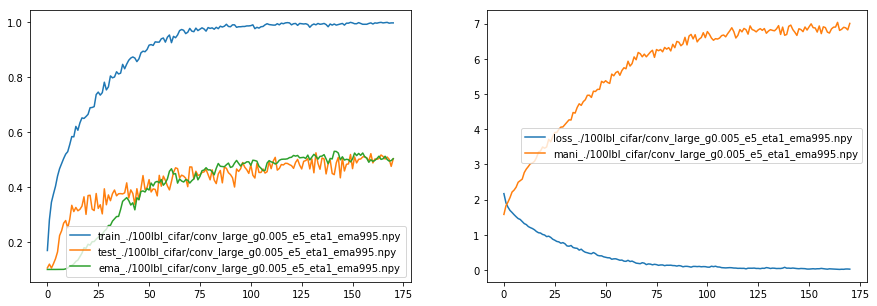

Epoch: 171,global_stp: 3440, xloss: 0.03088, maniloss: 6.75340, train: 99.70%, test: 49.37,test_ma: 51.27%
Epoch: 172,global_stp: 3460, xloss: 0.04630, maniloss: 6.85801, train: 99.30%, test: 48.50,test_ma: 49.57%
Epoch: 173,global_stp: 3480, xloss: 0.04064, maniloss: 6.81132, train: 99.60%, test: 47.82,test_ma: 50.54%
Epoch: 174,global_stp: 3500, xloss: 0.03443, maniloss: 6.83624, train: 99.80%, test: 50.20,test_ma: 50.91%
Epoch: 175,global_stp: 3520, xloss: 0.03111, maniloss: 6.72248, train: 99.60%, test: 48.02,test_ma: 51.34%
Epoch: 176,global_stp: 3540, xloss: 0.03928, maniloss: 6.94168, train: 99.60%, test: 48.46,test_ma: 52.43%
Epoch: 177,global_stp: 3560, xloss: 0.03631, maniloss: 6.86788, train: 99.60%, test: 50.27,test_ma: 51.85%
Epoch: 178,global_stp: 3580, xloss: 0.03926, maniloss: 6.85475, train: 99.30%, test: 49.46,test_ma: 52.15%
Epoch: 179,global_stp: 3600, xloss: 0.03316, maniloss: 6.84955, train: 99.50%, test: 52.53,test_ma: 52.11%
Epoch: 180,global_stp: 3620, xloss: 0

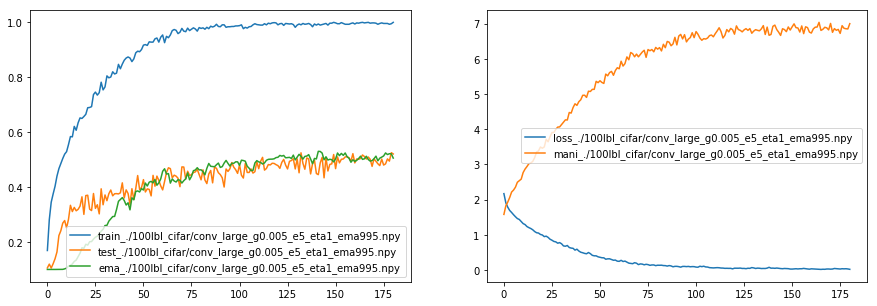

Epoch: 181,global_stp: 3640, xloss: 0.03444, maniloss: 6.81863, train: 99.60%, test: 52.25,test_ma: 50.18%
Epoch: 182,global_stp: 3660, xloss: 0.03232, maniloss: 7.00146, train: 99.50%, test: 48.64,test_ma: 50.71%
Epoch: 183,global_stp: 3680, xloss: 0.03794, maniloss: 6.80741, train: 99.10%, test: 49.69,test_ma: 51.86%
Epoch: 184,global_stp: 3700, xloss: 0.03873, maniloss: 6.72592, train: 99.30%, test: 49.20,test_ma: 52.90%
Epoch: 185,global_stp: 3720, xloss: 0.03709, maniloss: 6.87356, train: 99.60%, test: 49.99,test_ma: 52.89%
Epoch: 186,global_stp: 3740, xloss: 0.03043, maniloss: 6.94134, train: 99.60%, test: 52.17,test_ma: 51.94%
Epoch: 187,global_stp: 3760, xloss: 0.03311, maniloss: 6.83606, train: 99.50%, test: 51.54,test_ma: 52.31%
Epoch: 188,global_stp: 3780, xloss: 0.04679, maniloss: 6.85148, train: 99.00%, test: 50.85,test_ma: 52.48%
Epoch: 189,global_stp: 3800, xloss: 0.04765, maniloss: 6.88928, train: 99.10%, test: 48.41,test_ma: 51.70%
Epoch: 190,global_stp: 3820, xloss: 0

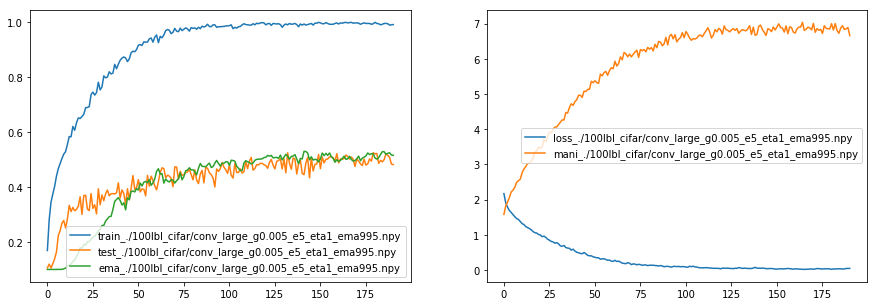

Epoch: 191,global_stp: 3840, xloss: 0.04366, maniloss: 6.85763, train: 99.20%, test: 50.99,test_ma: 52.59%
Epoch: 192,global_stp: 3860, xloss: 0.04424, maniloss: 6.88842, train: 99.10%, test: 48.99,test_ma: 52.24%
Epoch: 193,global_stp: 3880, xloss: 0.03581, maniloss: 6.93140, train: 99.90%, test: 49.52,test_ma: 52.19%
Epoch: 194,global_stp: 3900, xloss: 0.04297, maniloss: 6.87131, train: 99.10%, test: 50.01,test_ma: 52.21%
Epoch: 195,global_stp: 3920, xloss: 0.03596, maniloss: 6.88095, train: 99.40%, test: 53.27,test_ma: 49.93%
Epoch: 196,global_stp: 3940, xloss: 0.05317, maniloss: 6.87287, train: 98.80%, test: 49.12,test_ma: 49.23%
Epoch: 197,global_stp: 3960, xloss: 0.05651, maniloss: 6.75021, train: 98.90%, test: 47.72,test_ma: 49.03%
Epoch: 198,global_stp: 3980, xloss: 0.04624, maniloss: 6.69754, train: 99.30%, test: 51.51,test_ma: 49.86%
Epoch: 199,global_stp: 4000, xloss: 0.05351, maniloss: 6.87275, train: 99.10%, test: 47.94,test_ma: 51.53%
Epoch: 200,global_stp: 4020, xloss: 0

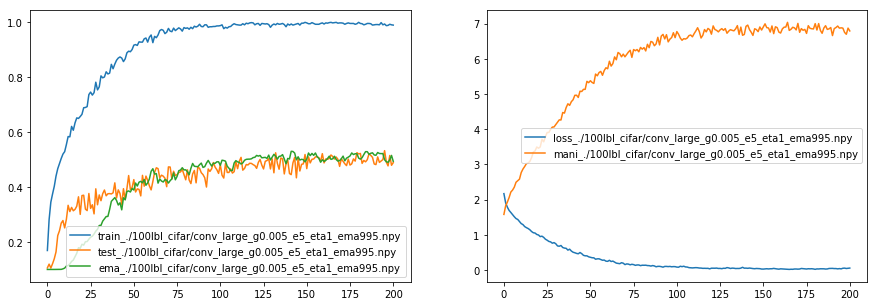

Epoch: 201,global_stp: 4040, xloss: 0.04606, maniloss: 6.71081, train: 99.40%, test: 47.00,test_ma: 48.80%
Epoch: 202,global_stp: 4060, xloss: 0.03121, maniloss: 6.95510, train: 99.60%, test: 49.52,test_ma: 50.55%
Epoch: 203,global_stp: 4080, xloss: 0.02639, maniloss: 6.98062, train: 99.80%, test: 49.28,test_ma: 51.03%
Epoch: 204,global_stp: 4100, xloss: 0.01953, maniloss: 6.93855, train: 99.80%, test: 52.91,test_ma: 50.83%
Epoch: 205,global_stp: 4120, xloss: 0.01942, maniloss: 6.86738, train: 99.90%, test: 53.57,test_ma: 50.54%
Epoch: 206,global_stp: 4140, xloss: 0.01616, maniloss: 6.85413, train: 99.90%, test: 50.94,test_ma: 50.42%
Epoch: 207,global_stp: 4160, xloss: 0.02153, maniloss: 6.74221, train: 99.60%, test: 51.96,test_ma: 51.72%
Epoch: 208,global_stp: 4180, xloss: 0.02878, maniloss: 6.94511, train: 99.50%, test: 50.57,test_ma: 52.34%
Epoch: 209,global_stp: 4200, xloss: 0.02904, maniloss: 6.85868, train: 99.40%, test: 47.64,test_ma: 52.89%
Epoch: 210,global_stp: 4220, xloss: 0

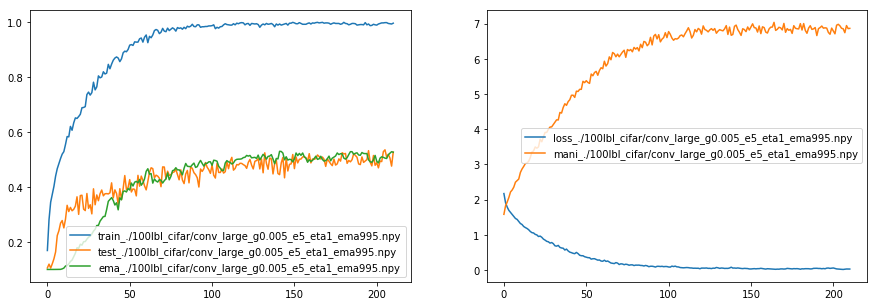

Epoch: 211,global_stp: 4240, xloss: 0.02504, maniloss: 6.72051, train: 99.60%, test: 49.33,test_ma: 53.48%
Epoch: 212,global_stp: 4260, xloss: 0.02176, maniloss: 6.83927, train: 99.80%, test: 52.75,test_ma: 53.32%
Epoch: 213,global_stp: 4280, xloss: 0.01755, maniloss: 7.01635, train: 99.80%, test: 50.18,test_ma: 52.44%
Epoch: 214,global_stp: 4300, xloss: 0.01810, maniloss: 6.84455, train: 100.00%, test: 52.42,test_ma: 52.86%
Epoch: 215,global_stp: 4320, xloss: 0.01825, maniloss: 6.85598, train: 99.90%, test: 50.30,test_ma: 53.10%
Epoch: 216,global_stp: 4340, xloss: 0.01478, maniloss: 6.69135, train: 99.90%, test: 52.26,test_ma: 53.89%
Epoch: 217,global_stp: 4360, xloss: 0.01416, maniloss: 6.98753, train: 99.90%, test: 52.22,test_ma: 54.91%
Epoch: 218,global_stp: 4380, xloss: 0.01404, maniloss: 6.75939, train: 100.00%, test: 53.62,test_ma: 54.54%
Epoch: 219,global_stp: 4400, xloss: 0.01085, maniloss: 6.84709, train: 100.00%, test: 53.19,test_ma: 54.91%
Epoch: 220,global_stp: 4420, xloss

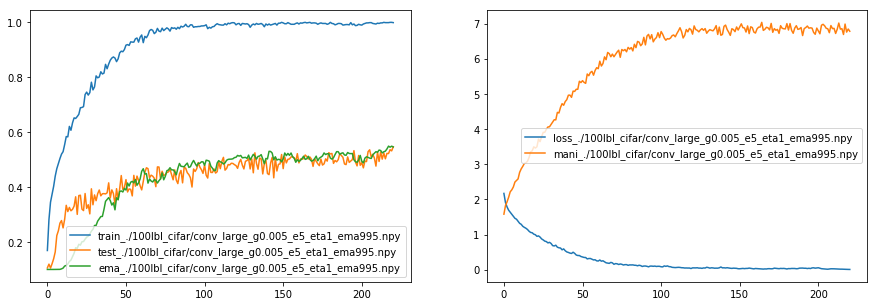

Epoch: 221,global_stp: 4440, xloss: 0.01418, maniloss: 6.69820, train: 100.00%, test: 53.09,test_ma: 53.95%
Epoch: 222,global_stp: 4460, xloss: 0.01524, maniloss: 6.88097, train: 99.80%, test: 52.87,test_ma: 54.44%
Epoch: 223,global_stp: 4480, xloss: 0.02565, maniloss: 6.72852, train: 99.60%, test: 49.73,test_ma: 54.58%
Epoch: 224,global_stp: 4500, xloss: 0.02593, maniloss: 6.69541, train: 99.80%, test: 52.44,test_ma: 54.74%
Epoch: 225,global_stp: 4520, xloss: 0.01719, maniloss: 6.61739, train: 99.90%, test: 53.21,test_ma: 52.57%
Epoch: 226,global_stp: 4540, xloss: 0.01805, maniloss: 6.71979, train: 99.90%, test: 53.71,test_ma: 54.02%
Epoch: 227,global_stp: 4560, xloss: 0.01570, maniloss: 6.76001, train: 99.70%, test: 52.28,test_ma: 52.83%
Epoch: 228,global_stp: 4580, xloss: 0.01630, maniloss: 6.77414, train: 100.00%, test: 51.75,test_ma: 53.03%
Epoch: 229,global_stp: 4600, xloss: 0.01438, maniloss: 6.60173, train: 99.90%, test: 52.42,test_ma: 53.26%
Epoch: 230,global_stp: 4620, xloss:

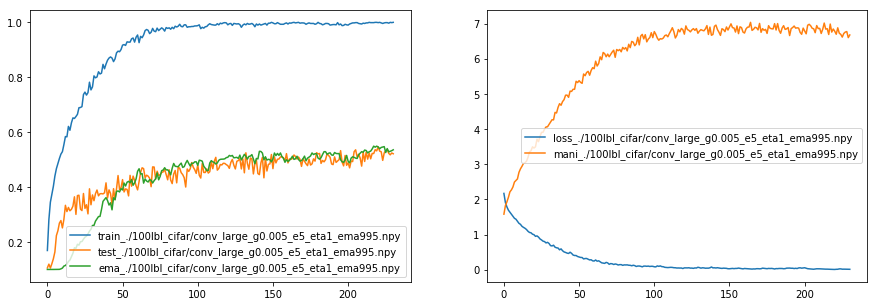

Epoch: 231,global_stp: 4640, xloss: 0.01381, maniloss: 6.60785, train: 99.90%, test: 51.71,test_ma: 53.54%
Epoch: 232,global_stp: 4660, xloss: 0.01368, maniloss: 6.66403, train: 100.00%, test: 53.16,test_ma: 53.76%
Epoch: 233,global_stp: 4680, xloss: 0.02145, maniloss: 6.78167, train: 99.60%, test: 49.58,test_ma: 54.00%
Epoch: 234,global_stp: 4700, xloss: 0.02482, maniloss: 6.62034, train: 99.50%, test: 52.28,test_ma: 54.26%
Epoch: 235,global_stp: 4720, xloss: 0.02866, maniloss: 6.58156, train: 99.50%, test: 52.46,test_ma: 53.81%
Epoch: 236,global_stp: 4740, xloss: 0.03953, maniloss: 6.70507, train: 99.00%, test: 48.49,test_ma: 53.24%
Epoch: 237,global_stp: 4760, xloss: 0.02231, maniloss: 6.65058, train: 99.80%, test: 49.06,test_ma: 54.75%
Epoch: 238,global_stp: 4780, xloss: 0.02761, maniloss: 6.53234, train: 99.50%, test: 51.67,test_ma: 54.57%
Epoch: 239,global_stp: 4800, xloss: 0.04066, maniloss: 6.71138, train: 99.00%, test: 49.33,test_ma: 54.78%
Epoch: 240,global_stp: 4820, xloss: 

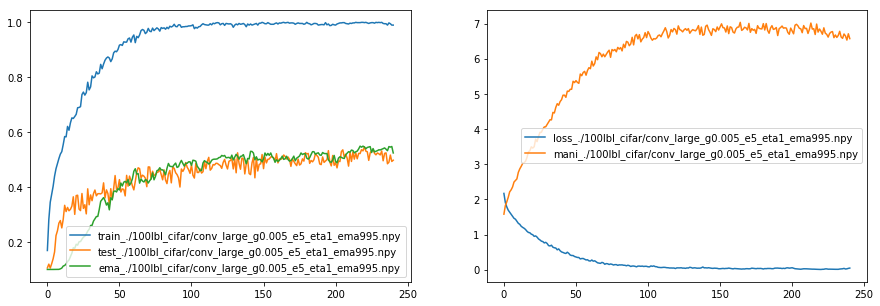

Epoch: 241,global_stp: 4840, xloss: 0.04842, maniloss: 6.67632, train: 99.40%, test: 46.40,test_ma: 48.15%
Epoch: 242,global_stp: 4860, xloss: 0.04218, maniloss: 6.68900, train: 99.50%, test: 48.07,test_ma: 48.88%
Epoch: 243,global_stp: 4880, xloss: 0.02801, maniloss: 6.69902, train: 99.70%, test: 50.41,test_ma: 51.46%
Epoch: 244,global_stp: 4900, xloss: 0.03008, maniloss: 6.60403, train: 99.30%, test: 49.54,test_ma: 52.39%
Epoch: 245,global_stp: 4920, xloss: 0.02288, maniloss: 6.75318, train: 99.90%, test: 50.76,test_ma: 53.29%
Epoch: 246,global_stp: 4940, xloss: 0.01908, maniloss: 6.88843, train: 99.90%, test: 52.39,test_ma: 52.59%
Epoch: 247,global_stp: 4960, xloss: 0.01851, maniloss: 6.65252, train: 99.70%, test: 51.21,test_ma: 53.25%
Epoch: 248,global_stp: 4980, xloss: 0.01805, maniloss: 6.70598, train: 99.80%, test: 52.58,test_ma: 53.11%
Epoch: 249,global_stp: 5000, xloss: 0.01433, maniloss: 6.73190, train: 99.90%, test: 53.24,test_ma: 52.59%
Epoch: 250,global_stp: 5020, xloss: 0

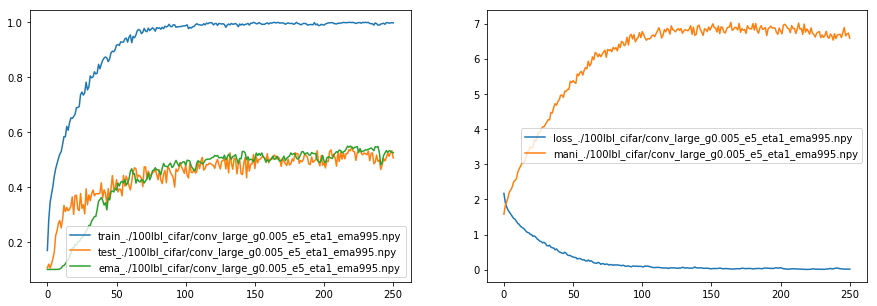

Epoch: 251,global_stp: 5040, xloss: 0.01908, maniloss: 6.60260, train: 99.80%, test: 54.19,test_ma: 52.88%
Epoch: 252,global_stp: 5060, xloss: 0.01409, maniloss: 6.51866, train: 100.00%, test: 52.36,test_ma: 52.00%
Epoch: 253,global_stp: 5080, xloss: 0.01615, maniloss: 6.66927, train: 100.00%, test: 50.80,test_ma: 53.91%
Epoch: 254,global_stp: 5100, xloss: 0.01357, maniloss: 6.67913, train: 99.90%, test: 52.73,test_ma: 53.20%
Epoch: 255,global_stp: 5120, xloss: 0.01124, maniloss: 6.54849, train: 100.00%, test: 52.73,test_ma: 53.25%
Epoch: 256,global_stp: 5140, xloss: 0.00911, maniloss: 6.54420, train: 100.00%, test: 52.25,test_ma: 53.67%
Epoch: 257,global_stp: 5160, xloss: 0.01379, maniloss: 6.59501, train: 99.90%, test: 49.63,test_ma: 54.58%
Epoch: 258,global_stp: 5180, xloss: 0.01746, maniloss: 6.58689, train: 99.60%, test: 51.93,test_ma: 55.55%
Epoch: 259,global_stp: 5200, xloss: 0.01548, maniloss: 6.60233, train: 99.80%, test: 52.33,test_ma: 55.46%
Epoch: 260,global_stp: 5220, xlos

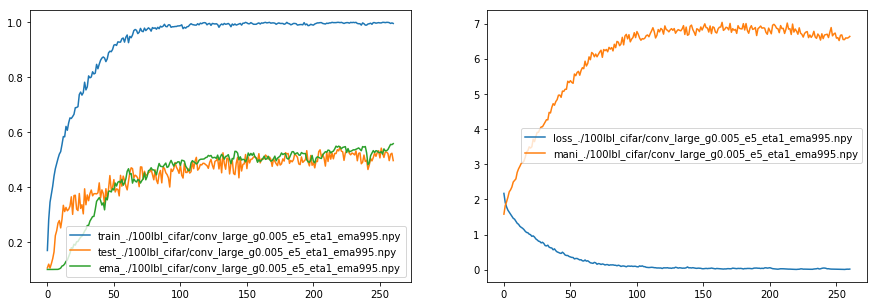

Epoch: 261,global_stp: 5240, xloss: 0.02282, maniloss: 6.49440, train: 99.60%, test: 52.76,test_ma: 55.54%
Epoch: 262,global_stp: 5260, xloss: 0.03291, maniloss: 6.61133, train: 99.20%, test: 51.35,test_ma: 55.44%
Epoch: 263,global_stp: 5280, xloss: 0.04934, maniloss: 6.56048, train: 99.20%, test: 49.65,test_ma: 50.56%
Epoch: 264,global_stp: 5300, xloss: 0.04881, maniloss: 6.54332, train: 99.10%, test: 47.77,test_ma: 52.08%
Epoch: 265,global_stp: 5320, xloss: 0.02951, maniloss: 6.57147, train: 99.90%, test: 51.73,test_ma: 51.52%
Epoch: 266,global_stp: 5340, xloss: 0.02194, maniloss: 6.65875, train: 99.80%, test: 50.59,test_ma: 53.81%
Epoch: 267,global_stp: 5360, xloss: 0.01823, maniloss: 6.57780, train: 99.90%, test: 52.97,test_ma: 54.29%
Epoch: 268,global_stp: 5380, xloss: 0.01544, maniloss: 6.60217, train: 100.00%, test: 53.28,test_ma: 53.01%
Epoch: 269,global_stp: 5400, xloss: 0.01363, maniloss: 6.68887, train: 99.90%, test: 53.77,test_ma: 52.97%
Epoch: 270,global_stp: 5420, xloss: 

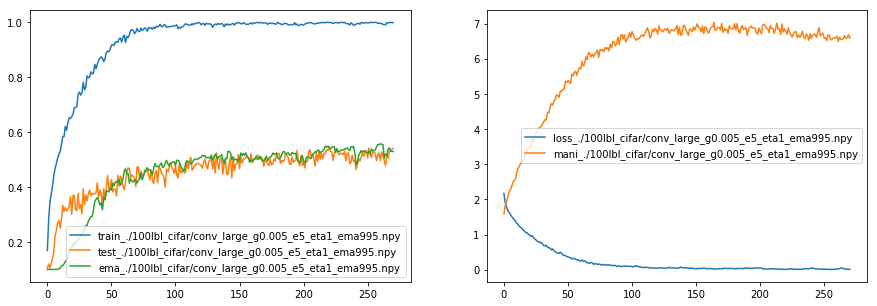

Epoch: 271,global_stp: 5440, xloss: 0.01140, maniloss: 6.64842, train: 100.00%, test: 53.15,test_ma: 52.38%
Epoch: 272,global_stp: 5460, xloss: 0.00786, maniloss: 6.46704, train: 100.00%, test: 54.17,test_ma: 52.21%
Epoch: 273,global_stp: 5480, xloss: 0.01228, maniloss: 6.55051, train: 99.80%, test: 50.63,test_ma: 53.34%
Epoch: 274,global_stp: 5500, xloss: 0.01117, maniloss: 6.53815, train: 100.00%, test: 54.45,test_ma: 52.96%
Epoch: 275,global_stp: 5520, xloss: 0.01239, maniloss: 6.54834, train: 100.00%, test: 52.20,test_ma: 53.58%
Epoch: 276,global_stp: 5540, xloss: 0.01057, maniloss: 6.55454, train: 100.00%, test: 54.54,test_ma: 53.39%
Epoch: 277,global_stp: 5560, xloss: 0.01248, maniloss: 6.37009, train: 100.00%, test: 52.80,test_ma: 52.98%
Epoch: 278,global_stp: 5580, xloss: 0.00746, maniloss: 6.55312, train: 100.00%, test: 52.72,test_ma: 54.61%
Epoch: 279,global_stp: 5600, xloss: 0.01097, maniloss: 6.40487, train: 99.90%, test: 54.33,test_ma: 54.93%
Epoch: 280,global_stp: 5620, x

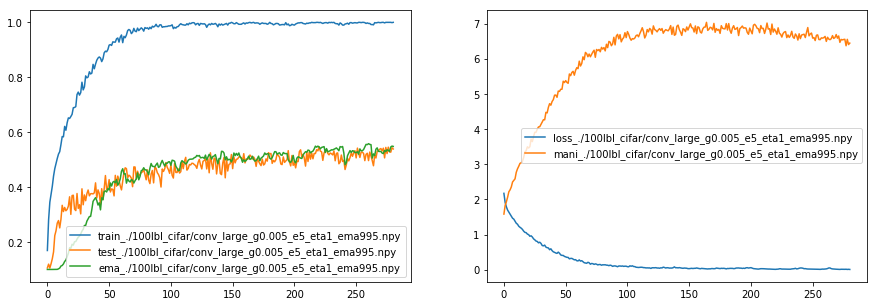

Epoch: 281,global_stp: 5640, xloss: 0.01056, maniloss: 6.32100, train: 100.00%, test: 54.92,test_ma: 55.11%
Epoch: 282,global_stp: 5660, xloss: 0.01309, maniloss: 6.37538, train: 99.80%, test: 53.24,test_ma: 54.83%
Epoch: 283,global_stp: 5680, xloss: 0.01525, maniloss: 6.52838, train: 99.80%, test: 50.36,test_ma: 55.41%
Epoch: 284,global_stp: 5700, xloss: 0.01922, maniloss: 6.32700, train: 99.60%, test: 51.65,test_ma: 55.16%
Epoch: 285,global_stp: 5720, xloss: 0.02047, maniloss: 6.53850, train: 99.90%, test: 48.80,test_ma: 55.24%
Epoch: 286,global_stp: 5740, xloss: 0.02013, maniloss: 6.41401, train: 99.60%, test: 54.26,test_ma: 55.55%
Epoch: 287,global_stp: 5760, xloss: 0.02894, maniloss: 6.35914, train: 99.30%, test: 48.87,test_ma: 54.61%
Epoch: 288,global_stp: 5780, xloss: 0.02549, maniloss: 6.46444, train: 99.60%, test: 53.25,test_ma: 53.72%
Epoch: 289,global_stp: 5800, xloss: 0.03568, maniloss: 6.49378, train: 99.40%, test: 45.50,test_ma: 53.93%
Epoch: 290,global_stp: 5820, xloss: 

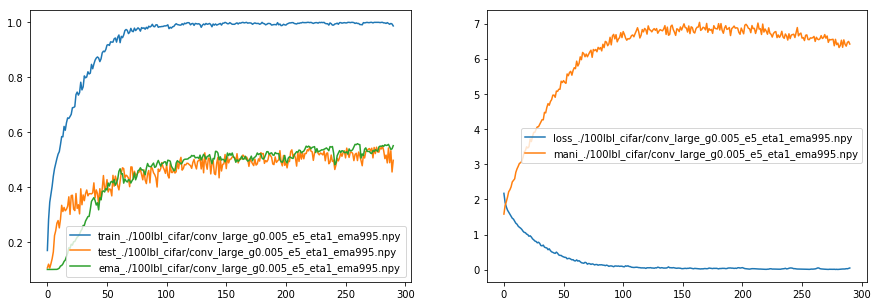

Epoch: 291,global_stp: 5840, xloss: 0.06982, maniloss: 6.24053, train: 98.50%, test: 48.25,test_ma: 53.85%
Epoch: 292,global_stp: 5860, xloss: 0.05605, maniloss: 6.59794, train: 98.70%, test: 46.85,test_ma: 50.26%
Epoch: 293,global_stp: 5880, xloss: 0.04369, maniloss: 6.49967, train: 99.30%, test: 46.46,test_ma: 48.52%
Epoch: 294,global_stp: 5900, xloss: 0.04517, maniloss: 6.61590, train: 98.80%, test: 48.58,test_ma: 48.33%
Epoch: 295,global_stp: 5920, xloss: 0.03309, maniloss: 6.52797, train: 99.50%, test: 51.46,test_ma: 48.94%
Epoch: 296,global_stp: 5940, xloss: 0.02188, maniloss: 6.69566, train: 99.60%, test: 52.00,test_ma: 49.22%
Epoch: 297,global_stp: 5960, xloss: 0.01731, maniloss: 6.65059, train: 99.90%, test: 51.31,test_ma: 51.00%
Epoch: 298,global_stp: 5980, xloss: 0.01747, maniloss: 6.67652, train: 99.80%, test: 53.66,test_ma: 51.12%
Epoch: 299,global_stp: 6000, xloss: 0.01694, maniloss: 6.61302, train: 99.90%, test: 51.64,test_ma: 51.05%
Epoch: 300,global_stp: 6020, xloss: 0

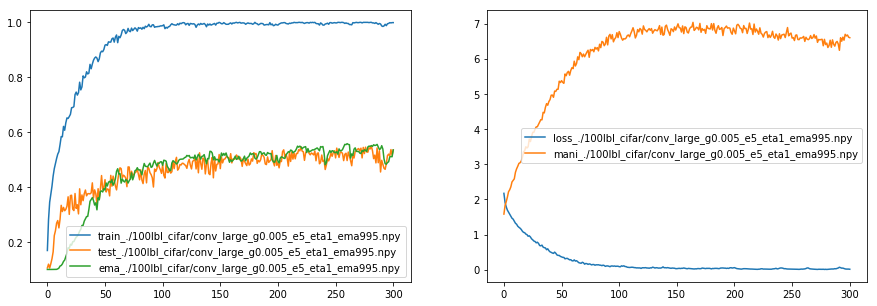

Epoch: 301,global_stp: 6040, xloss: 0.00904, maniloss: 6.68310, train: 100.00%, test: 53.61,test_ma: 54.42%
Epoch: 302,global_stp: 6060, xloss: 0.01428, maniloss: 6.49574, train: 99.60%, test: 53.12,test_ma: 54.90%
Epoch: 303,global_stp: 6080, xloss: 0.01240, maniloss: 6.56990, train: 100.00%, test: 53.66,test_ma: 54.88%
Epoch: 304,global_stp: 6100, xloss: 0.00659, maniloss: 6.53608, train: 100.00%, test: 55.18,test_ma: 55.70%
Epoch: 305,global_stp: 6120, xloss: 0.00706, maniloss: 6.58663, train: 100.00%, test: 53.19,test_ma: 55.74%
Epoch: 306,global_stp: 6140, xloss: 0.00557, maniloss: 6.44024, train: 100.00%, test: 54.11,test_ma: 55.71%
Epoch: 307,global_stp: 6160, xloss: 0.00637, maniloss: 6.46870, train: 100.00%, test: 55.01,test_ma: 55.86%
Epoch: 308,global_stp: 6180, xloss: 0.01142, maniloss: 6.51380, train: 99.90%, test: 52.39,test_ma: 56.01%
Epoch: 309,global_stp: 6200, xloss: 0.01194, maniloss: 6.29343, train: 99.80%, test: 54.18,test_ma: 56.35%
Epoch: 310,global_stp: 6220, xl

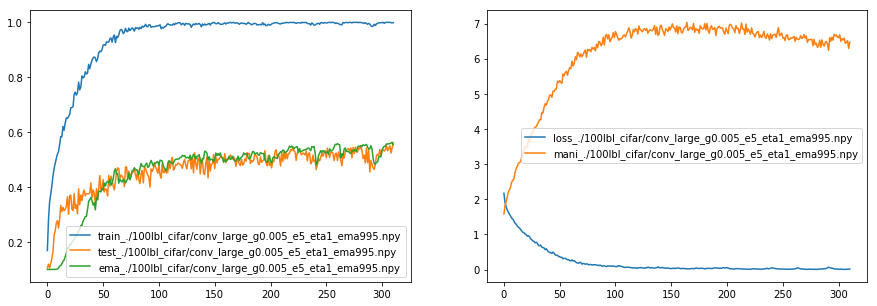

Epoch: 311,global_stp: 6240, xloss: 0.02992, maniloss: 6.34442, train: 99.30%, test: 51.27,test_ma: 54.87%
Epoch: 312,global_stp: 6260, xloss: 0.03905, maniloss: 6.36231, train: 98.90%, test: 48.54,test_ma: 52.91%
Epoch: 313,global_stp: 6280, xloss: 0.04107, maniloss: 6.43438, train: 99.10%, test: 50.63,test_ma: 54.77%
Epoch: 314,global_stp: 6300, xloss: 0.03946, maniloss: 6.44932, train: 99.10%, test: 51.92,test_ma: 53.81%
Epoch: 315,global_stp: 6320, xloss: 0.03284, maniloss: 6.65229, train: 99.20%, test: 49.97,test_ma: 53.39%
Epoch: 316,global_stp: 6340, xloss: 0.03688, maniloss: 6.45805, train: 99.20%, test: 50.17,test_ma: 53.33%
Epoch: 317,global_stp: 6360, xloss: 0.03845, maniloss: 6.64394, train: 99.10%, test: 50.47,test_ma: 52.52%
Epoch: 318,global_stp: 6380, xloss: 0.03039, maniloss: 6.57536, train: 99.40%, test: 54.11,test_ma: 51.88%
Epoch: 319,global_stp: 6400, xloss: 0.06040, maniloss: 6.52945, train: 99.00%, test: 48.92,test_ma: 52.07%
Epoch: 320,global_stp: 6420, xloss: 0

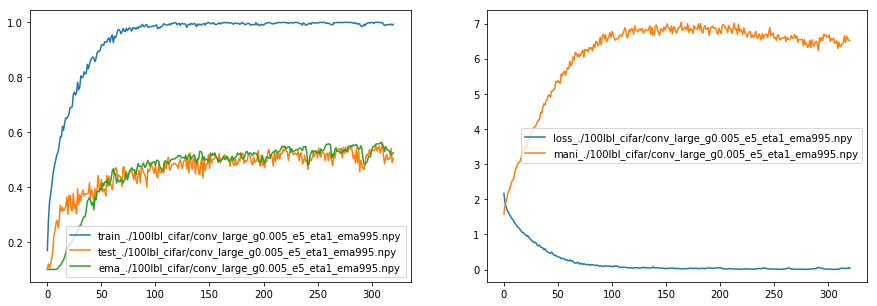

Epoch: 321,global_stp: 6440, xloss: 0.02814, maniloss: 6.61218, train: 99.70%, test: 52.99,test_ma: 52.53%
Epoch: 322,global_stp: 6460, xloss: 0.02589, maniloss: 6.57620, train: 99.50%, test: 53.17,test_ma: 52.26%
Epoch: 323,global_stp: 6480, xloss: 0.01175, maniloss: 6.63458, train: 100.00%, test: 55.78,test_ma: 52.92%
Epoch: 324,global_stp: 6500, xloss: 0.01453, maniloss: 6.49352, train: 99.70%, test: 54.62,test_ma: 51.20%
Epoch: 325,global_stp: 6520, xloss: 0.02017, maniloss: 6.55717, train: 99.70%, test: 51.36,test_ma: 51.03%
Epoch: 326,global_stp: 6540, xloss: 0.02389, maniloss: 6.52529, train: 99.60%, test: 51.82,test_ma: 52.30%
Epoch: 327,global_stp: 6560, xloss: 0.01488, maniloss: 6.58194, train: 99.80%, test: 48.09,test_ma: 54.00%
Epoch: 328,global_stp: 6580, xloss: 0.01152, maniloss: 6.63443, train: 100.00%, test: 53.02,test_ma: 54.56%
Epoch: 329,global_stp: 6600, xloss: 0.01566, maniloss: 6.44640, train: 99.70%, test: 50.29,test_ma: 54.44%
Epoch: 330,global_stp: 6620, xloss:

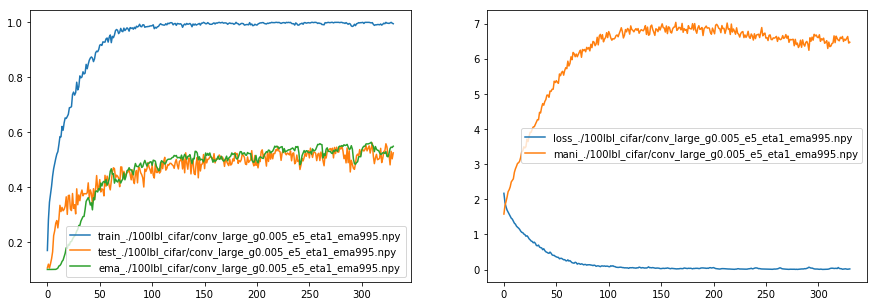

Epoch: 331,global_stp: 6640, xloss: 0.01589, maniloss: 6.38068, train: 99.90%, test: 54.37,test_ma: 53.25%
Epoch: 332,global_stp: 6660, xloss: 0.01834, maniloss: 6.49593, train: 99.40%, test: 51.04,test_ma: 53.70%
Epoch: 333,global_stp: 6680, xloss: 0.01708, maniloss: 6.50525, train: 99.80%, test: 52.99,test_ma: 55.41%
Epoch: 334,global_stp: 6700, xloss: 0.01082, maniloss: 6.52984, train: 99.90%, test: 51.87,test_ma: 55.33%
Epoch: 335,global_stp: 6720, xloss: 0.01952, maniloss: 6.46620, train: 99.80%, test: 55.87,test_ma: 55.10%
Epoch: 336,global_stp: 6740, xloss: 0.00997, maniloss: 6.24639, train: 100.00%, test: 54.71,test_ma: 54.48%
Epoch: 337,global_stp: 6760, xloss: 0.00662, maniloss: 6.50413, train: 100.00%, test: 55.10,test_ma: 54.10%
Epoch: 338,global_stp: 6780, xloss: 0.00644, maniloss: 6.24580, train: 100.00%, test: 54.61,test_ma: 54.21%
Epoch: 339,global_stp: 6800, xloss: 0.00685, maniloss: 6.24400, train: 100.00%, test: 55.47,test_ma: 53.85%
Epoch: 340,global_stp: 6820, xlos

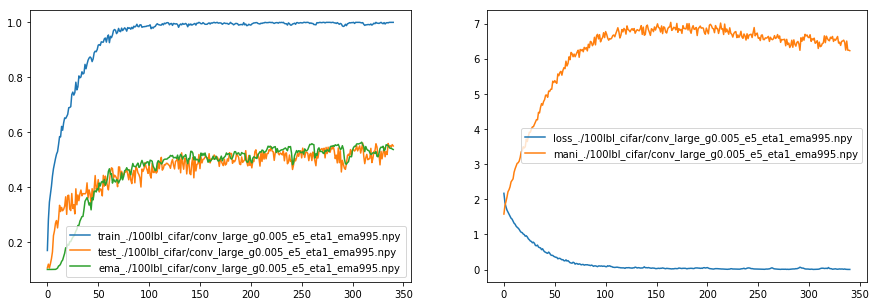

Epoch: 341,global_stp: 6840, xloss: 0.00611, maniloss: 6.28583, train: 100.00%, test: 52.50,test_ma: 54.04%
Epoch: 342,global_stp: 6860, xloss: 0.00515, maniloss: 6.23972, train: 100.00%, test: 54.07,test_ma: 55.21%
Epoch: 343,global_stp: 6880, xloss: 0.00761, maniloss: 6.20633, train: 100.00%, test: 53.89,test_ma: 55.27%
Epoch: 344,global_stp: 6900, xloss: 0.00749, maniloss: 6.20261, train: 100.00%, test: 56.20,test_ma: 54.44%
Epoch: 345,global_stp: 6920, xloss: 0.00778, maniloss: 6.05535, train: 100.00%, test: 54.58,test_ma: 54.65%
Epoch: 346,global_stp: 6940, xloss: 0.00544, maniloss: 6.02780, train: 100.00%, test: 55.78,test_ma: 55.24%
Epoch: 347,global_stp: 6960, xloss: 0.00469, maniloss: 6.11439, train: 100.00%, test: 55.34,test_ma: 55.96%
Epoch: 348,global_stp: 6980, xloss: 0.00513, maniloss: 6.07785, train: 100.00%, test: 55.13,test_ma: 56.29%
Epoch: 349,global_stp: 7000, xloss: 0.00633, maniloss: 6.05526, train: 100.00%, test: 56.34,test_ma: 55.65%
Epoch: 350,global_stp: 7020,

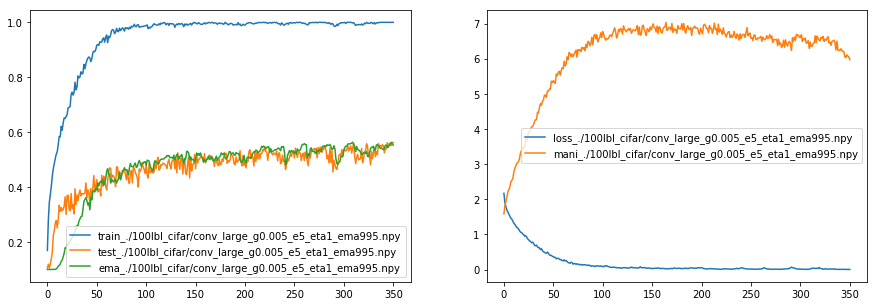

Epoch: 351,global_stp: 7040, xloss: 0.00878, maniloss: 5.98298, train: 100.00%, test: 54.34,test_ma: 55.91%
Epoch: 352,global_stp: 7060, xloss: 0.00564, maniloss: 6.02464, train: 100.00%, test: 55.43,test_ma: 56.44%
Epoch: 353,global_stp: 7080, xloss: 0.00532, maniloss: 5.92595, train: 100.00%, test: 56.18,test_ma: 55.69%
Epoch: 354,global_stp: 7100, xloss: 0.00558, maniloss: 6.01584, train: 100.00%, test: 55.29,test_ma: 55.70%
Epoch: 355,global_stp: 7120, xloss: 0.00512, maniloss: 5.93090, train: 100.00%, test: 55.44,test_ma: 55.60%
Epoch: 356,global_stp: 7140, xloss: 0.00711, maniloss: 5.86767, train: 100.00%, test: 53.74,test_ma: 56.29%
Epoch: 357,global_stp: 7160, xloss: 0.00621, maniloss: 5.87246, train: 100.00%, test: 55.46,test_ma: 56.51%
Epoch: 358,global_stp: 7180, xloss: 0.00450, maniloss: 5.85538, train: 100.00%, test: 55.41,test_ma: 56.43%
Epoch: 359,global_stp: 7200, xloss: 0.00433, maniloss: 5.77525, train: 100.00%, test: 55.78,test_ma: 56.25%
Epoch: 360,global_stp: 7220,

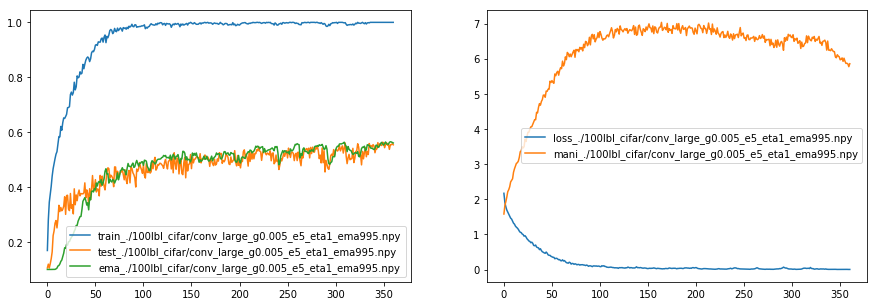

Epoch: 361,global_stp: 7240, xloss: 0.00529, maniloss: 5.80393, train: 100.00%, test: 55.09,test_ma: 56.77%
Epoch: 362,global_stp: 7260, xloss: 0.00410, maniloss: 5.81086, train: 100.00%, test: 56.16,test_ma: 56.87%
Epoch: 363,global_stp: 7280, xloss: 0.00497, maniloss: 5.70601, train: 100.00%, test: 56.46,test_ma: 56.35%
Epoch: 364,global_stp: 7300, xloss: 0.00431, maniloss: 5.61173, train: 100.00%, test: 55.91,test_ma: 56.12%
Epoch: 365,global_stp: 7320, xloss: 0.00462, maniloss: 5.61010, train: 100.00%, test: 56.55,test_ma: 56.05%
Epoch: 366,global_stp: 7340, xloss: 0.00639, maniloss: 5.50735, train: 100.00%, test: 54.49,test_ma: 55.71%
Epoch: 367,global_stp: 7360, xloss: 0.00482, maniloss: 5.65131, train: 100.00%, test: 55.26,test_ma: 56.31%
Epoch: 368,global_stp: 7380, xloss: 0.00517, maniloss: 5.63436, train: 100.00%, test: 55.48,test_ma: 55.93%
Epoch: 369,global_stp: 7400, xloss: 0.00646, maniloss: 5.59970, train: 100.00%, test: 55.32,test_ma: 55.31%
Epoch: 370,global_stp: 7420,

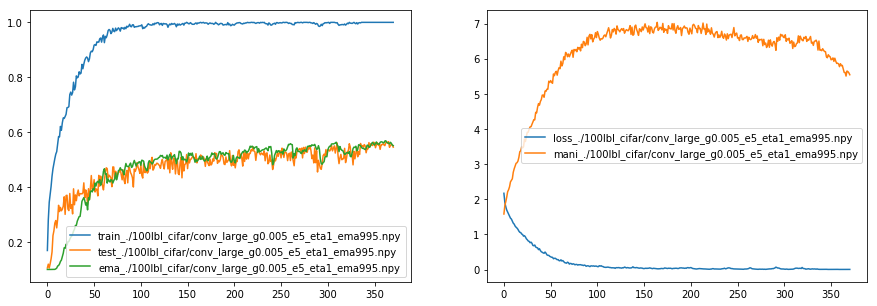

Epoch: 371,global_stp: 7440, xloss: 0.00964, maniloss: 5.58052, train: 100.00%, test: 53.07,test_ma: 54.86%
Epoch: 372,global_stp: 7460, xloss: 0.00921, maniloss: 5.52025, train: 99.90%, test: 53.58,test_ma: 56.20%
Epoch: 373,global_stp: 7480, xloss: 0.00574, maniloss: 5.64563, train: 100.00%, test: 54.87,test_ma: 56.63%
Epoch: 374,global_stp: 7500, xloss: 0.00678, maniloss: 5.54157, train: 100.00%, test: 55.40,test_ma: 56.04%
Epoch: 375,global_stp: 7520, xloss: 0.00673, maniloss: 5.55732, train: 99.90%, test: 55.13,test_ma: 56.25%
Epoch: 376,global_stp: 7540, xloss: 0.04488, maniloss: 5.51159, train: 98.70%, test: 48.35,test_ma: 55.36%
Epoch: 377,global_stp: 7560, xloss: 0.13981, maniloss: 5.44885, train: 96.00%, test: 44.31,test_ma: 50.00%
Epoch: 378,global_stp: 7580, xloss: 0.19163, maniloss: 5.76894, train: 94.40%, test: 47.27,test_ma: 50.44%
Epoch: 379,global_stp: 7600, xloss: 0.13753, maniloss: 5.90581, train: 96.00%, test: 50.53,test_ma: 47.90%
Epoch: 380,global_stp: 7620, xloss

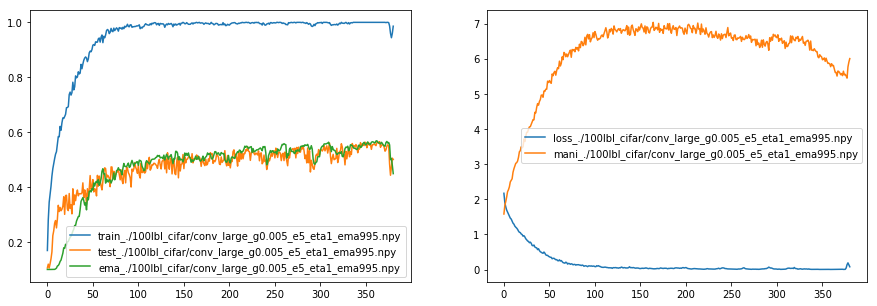

Epoch: 381,global_stp: 7640, xloss: 0.08353, maniloss: 6.23619, train: 97.60%, test: 42.55,test_ma: 46.71%
Epoch: 382,global_stp: 7660, xloss: 0.05127, maniloss: 6.20090, train: 99.10%, test: 41.75,test_ma: 49.01%
Epoch: 383,global_stp: 7680, xloss: 0.04833, maniloss: 6.35908, train: 98.70%, test: 51.84,test_ma: 52.02%
Epoch: 384,global_stp: 7700, xloss: 0.03185, maniloss: 6.26938, train: 99.30%, test: 53.28,test_ma: 51.78%
Epoch: 385,global_stp: 7720, xloss: 0.01900, maniloss: 6.27168, train: 99.80%, test: 55.03,test_ma: 52.48%
Epoch: 386,global_stp: 7740, xloss: 0.01243, maniloss: 6.26668, train: 99.90%, test: 54.78,test_ma: 52.18%
Epoch: 387,global_stp: 7760, xloss: 0.00811, maniloss: 6.31765, train: 100.00%, test: 54.19,test_ma: 53.63%
Epoch: 388,global_stp: 7780, xloss: 0.00855, maniloss: 6.28564, train: 99.90%, test: 54.97,test_ma: 54.30%
Epoch: 389,global_stp: 7800, xloss: 0.01046, maniloss: 6.28810, train: 100.00%, test: 54.67,test_ma: 54.04%
Epoch: 390,global_stp: 7820, xloss:

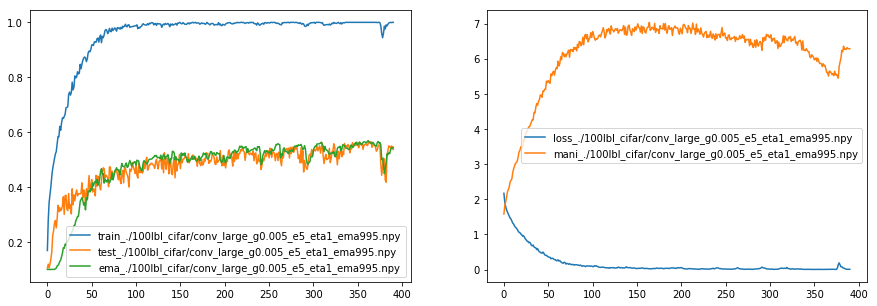

Epoch: 391,global_stp: 7840, xloss: 0.00790, maniloss: 6.18443, train: 99.90%, test: 54.57,test_ma: 54.97%
Epoch: 392,global_stp: 7860, xloss: 0.00595, maniloss: 6.21865, train: 100.00%, test: 54.88,test_ma: 54.30%
Epoch: 393,global_stp: 7880, xloss: 0.00594, maniloss: 6.24264, train: 100.00%, test: 54.49,test_ma: 54.21%
Epoch: 394,global_stp: 7900, xloss: 0.00559, maniloss: 6.20409, train: 100.00%, test: 55.03,test_ma: 54.64%
Epoch: 395,global_stp: 7920, xloss: 0.00493, maniloss: 6.04923, train: 100.00%, test: 55.17,test_ma: 54.89%
Epoch: 396,global_stp: 7940, xloss: 0.00556, maniloss: 6.04281, train: 100.00%, test: 54.28,test_ma: 55.06%
Epoch: 397,global_stp: 7960, xloss: 0.00635, maniloss: 6.07934, train: 100.00%, test: 54.25,test_ma: 55.55%
Epoch: 398,global_stp: 7980, xloss: 0.00424, maniloss: 6.08823, train: 100.00%, test: 55.48,test_ma: 55.73%
Epoch: 399,global_stp: 8000, xloss: 0.00616, maniloss: 5.80996, train: 100.00%, test: 54.94,test_ma: 55.87%
Epoch: 400,global_stp: 8020, 

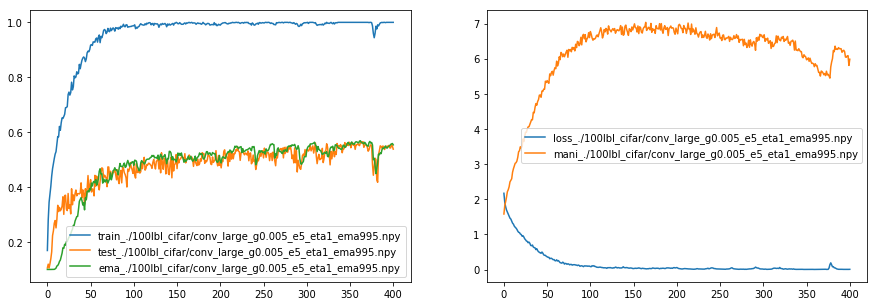

Epoch: 401,global_stp: 8040, xloss: 0.01437, maniloss: 5.96315, train: 99.80%, test: 53.83,test_ma: 55.83%
Epoch: 402,global_stp: 8060, xloss: 0.00644, maniloss: 5.95965, train: 100.00%, test: 55.16,test_ma: 55.49%
Epoch: 403,global_stp: 8080, xloss: 0.01121, maniloss: 5.96433, train: 99.90%, test: 54.39,test_ma: 55.51%
Epoch: 404,global_stp: 8100, xloss: 0.00576, maniloss: 5.98859, train: 100.00%, test: 55.39,test_ma: 55.69%
Epoch: 405,global_stp: 8120, xloss: 0.00581, maniloss: 5.84867, train: 100.00%, test: 54.26,test_ma: 55.51%
Epoch: 406,global_stp: 8140, xloss: 0.00601, maniloss: 5.81593, train: 100.00%, test: 55.06,test_ma: 55.33%
Epoch: 407,global_stp: 8160, xloss: 0.00492, maniloss: 6.09464, train: 100.00%, test: 56.35,test_ma: 55.25%
Epoch: 408,global_stp: 8180, xloss: 0.00572, maniloss: 5.84669, train: 100.00%, test: 54.71,test_ma: 55.32%
Epoch: 409,global_stp: 8200, xloss: 0.00650, maniloss: 5.91133, train: 100.00%, test: 55.18,test_ma: 55.85%
Epoch: 410,global_stp: 8220, x

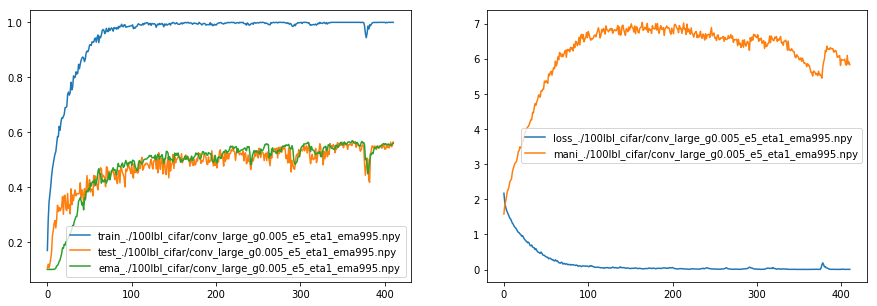

Epoch: 411,global_stp: 8240, xloss: 0.00837, maniloss: 5.81692, train: 99.90%, test: 55.11,test_ma: 55.85%
Epoch: 412,global_stp: 8260, xloss: 0.00483, maniloss: 5.84604, train: 100.00%, test: 55.54,test_ma: 55.99%
Epoch: 413,global_stp: 8280, xloss: 0.00529, maniloss: 5.82104, train: 100.00%, test: 56.40,test_ma: 55.82%
Epoch: 414,global_stp: 8300, xloss: 0.00557, maniloss: 5.72881, train: 100.00%, test: 56.49,test_ma: 55.90%
Epoch: 415,global_stp: 8320, xloss: 0.00546, maniloss: 5.75892, train: 100.00%, test: 55.15,test_ma: 56.16%
Epoch: 416,global_stp: 8340, xloss: 0.00700, maniloss: 5.72982, train: 100.00%, test: 55.16,test_ma: 55.86%
Epoch: 417,global_stp: 8360, xloss: 0.00506, maniloss: 5.61274, train: 100.00%, test: 55.84,test_ma: 55.61%
Epoch: 418,global_stp: 8380, xloss: 0.00287, maniloss: 5.53323, train: 100.00%, test: 55.97,test_ma: 55.63%
Epoch: 419,global_stp: 8400, xloss: 0.00469, maniloss: 5.54107, train: 100.00%, test: 55.82,test_ma: 56.08%
Epoch: 420,global_stp: 8420, 

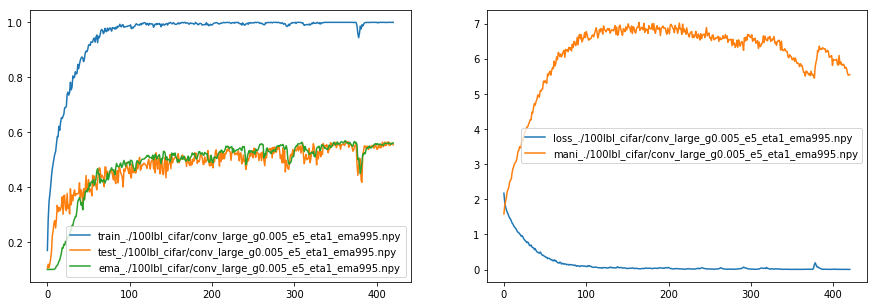

Epoch: 421,global_stp: 8440, xloss: 0.00463, maniloss: 5.46892, train: 100.00%, test: 54.99,test_ma: 56.47%
Epoch: 422,global_stp: 8460, xloss: 0.00587, maniloss: 5.48200, train: 100.00%, test: 55.70,test_ma: 56.56%
Epoch: 423,global_stp: 8480, xloss: 0.00583, maniloss: 5.39995, train: 100.00%, test: 56.24,test_ma: 56.62%
Epoch: 424,global_stp: 8500, xloss: 0.00737, maniloss: 5.45784, train: 100.00%, test: 56.25,test_ma: 56.02%
Epoch: 425,global_stp: 8520, xloss: 0.00454, maniloss: 5.47824, train: 100.00%, test: 55.60,test_ma: 55.74%
Epoch: 426,global_stp: 8540, xloss: 0.00490, maniloss: 5.47246, train: 100.00%, test: 55.79,test_ma: 55.77%
Epoch: 427,global_stp: 8560, xloss: 0.00419, maniloss: 5.39704, train: 100.00%, test: 56.23,test_ma: 55.59%
Epoch: 428,global_stp: 8580, xloss: 0.00477, maniloss: 5.36230, train: 100.00%, test: 55.73,test_ma: 55.55%
Epoch: 429,global_stp: 8600, xloss: 0.00471, maniloss: 5.36537, train: 100.00%, test: 54.86,test_ma: 56.14%
Epoch: 430,global_stp: 8620,

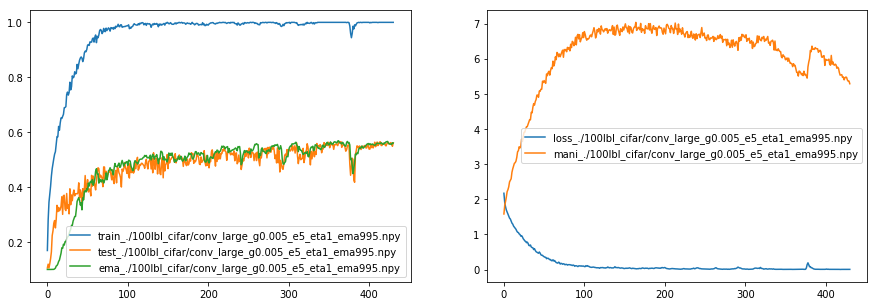

Epoch: 431,global_stp: 8640, xloss: 0.00523, maniloss: 5.39956, train: 100.00%, test: 55.89,test_ma: 55.79%
Epoch: 432,global_stp: 8660, xloss: 0.00450, maniloss: 5.30940, train: 100.00%, test: 55.32,test_ma: 55.78%
Epoch: 433,global_stp: 8680, xloss: 0.00556, maniloss: 5.22561, train: 100.00%, test: 55.96,test_ma: 56.01%
Epoch: 434,global_stp: 8700, xloss: 0.00550, maniloss: 5.23657, train: 100.00%, test: 56.00,test_ma: 56.15%
Epoch: 435,global_stp: 8720, xloss: 0.00559, maniloss: 5.26112, train: 100.00%, test: 56.71,test_ma: 56.13%
Epoch: 436,global_stp: 8740, xloss: 0.00625, maniloss: 5.22615, train: 99.90%, test: 56.42,test_ma: 55.88%
Epoch: 437,global_stp: 8760, xloss: 0.00771, maniloss: 5.22935, train: 100.00%, test: 55.06,test_ma: 55.62%
Epoch: 438,global_stp: 8780, xloss: 0.00561, maniloss: 5.28300, train: 100.00%, test: 56.23,test_ma: 55.15%
Epoch: 439,global_stp: 8800, xloss: 0.00948, maniloss: 5.24906, train: 99.80%, test: 50.49,test_ma: 55.28%
Epoch: 440,global_stp: 8820, x

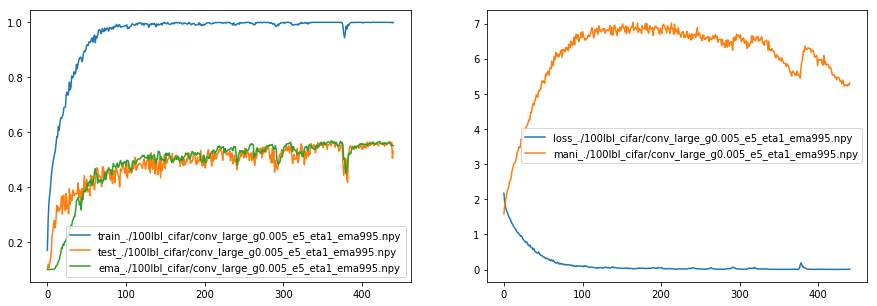

Epoch: 441,global_stp: 8840, xloss: 0.00667, maniloss: 5.34860, train: 100.00%, test: 55.13,test_ma: 55.55%
Epoch: 442,global_stp: 8860, xloss: 0.00684, maniloss: 5.36001, train: 100.00%, test: 54.92,test_ma: 56.31%
Epoch: 443,global_stp: 8880, xloss: 0.00721, maniloss: 5.39169, train: 100.00%, test: 55.13,test_ma: 56.21%
Epoch: 444,global_stp: 8900, xloss: 0.00937, maniloss: 5.36289, train: 100.00%, test: 55.39,test_ma: 56.20%
Epoch: 445,global_stp: 8920, xloss: 0.00623, maniloss: 5.28844, train: 100.00%, test: 55.52,test_ma: 56.71%
Epoch: 446,global_stp: 8940, xloss: 0.00617, maniloss: 5.28050, train: 99.90%, test: 54.96,test_ma: 56.70%
Epoch: 447,global_stp: 8960, xloss: 0.01932, maniloss: 5.29200, train: 99.70%, test: 56.75,test_ma: 56.10%
Epoch: 448,global_stp: 8980, xloss: 0.01982, maniloss: 5.22560, train: 99.70%, test: 53.59,test_ma: 54.87%
Epoch: 449,global_stp: 9000, xloss: 0.01943, maniloss: 5.52055, train: 99.70%, test: 50.53,test_ma: 54.16%
Epoch: 450,global_stp: 9020, xlo

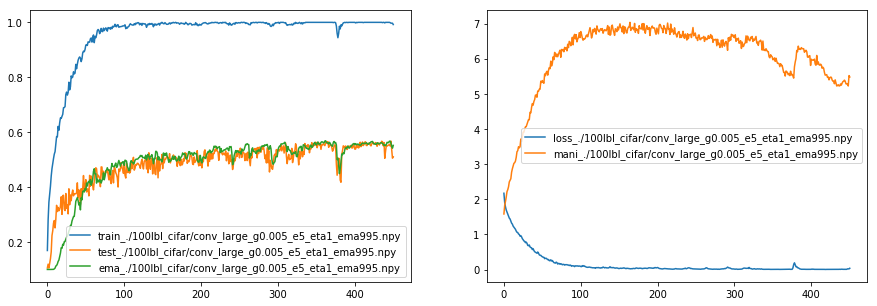

Epoch: 451,global_stp: 9040, xloss: 0.04523, maniloss: 5.75672, train: 98.90%, test: 52.48,test_ma: 52.15%
Epoch: 452,global_stp: 9060, xloss: 0.03825, maniloss: 5.83663, train: 99.20%, test: 43.67,test_ma: 50.82%
Epoch: 453,global_stp: 9080, xloss: 0.05010, maniloss: 5.95371, train: 98.50%, test: 49.61,test_ma: 53.47%
Epoch: 454,global_stp: 9100, xloss: 0.06081, maniloss: 5.82621, train: 98.80%, test: 49.63,test_ma: 52.45%
Epoch: 455,global_stp: 9120, xloss: 0.07583, maniloss: 6.00522, train: 98.10%, test: 47.55,test_ma: 51.18%
Epoch: 456,global_stp: 9140, xloss: 0.08633, maniloss: 6.02219, train: 97.90%, test: 49.31,test_ma: 53.45%
Epoch: 457,global_stp: 9160, xloss: 0.05484, maniloss: 6.12155, train: 98.60%, test: 50.78,test_ma: 50.12%
Epoch: 458,global_stp: 9180, xloss: 0.05519, maniloss: 6.06381, train: 98.40%, test: 49.48,test_ma: 49.83%
Epoch: 459,global_stp: 9200, xloss: 0.03898, maniloss: 6.35471, train: 99.50%, test: 53.16,test_ma: 49.82%
Epoch: 460,global_stp: 9220, xloss: 0

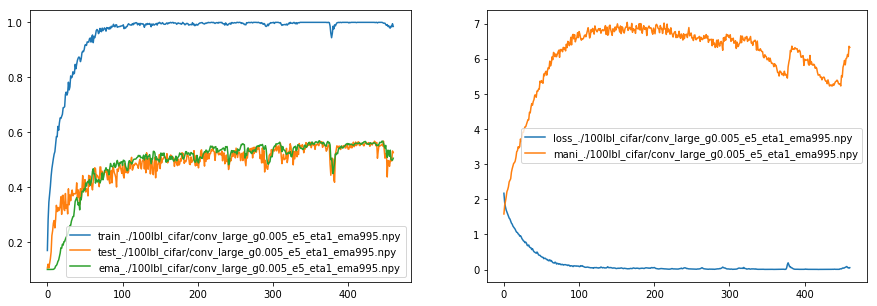

Epoch: 461,global_stp: 9240, xloss: 0.03555, maniloss: 6.19066, train: 99.20%, test: 51.59,test_ma: 49.10%
Epoch: 462,global_stp: 9260, xloss: 0.02249, maniloss: 6.06868, train: 99.70%, test: 52.48,test_ma: 50.56%
Epoch: 463,global_stp: 9280, xloss: 0.01238, maniloss: 6.26054, train: 99.90%, test: 55.89,test_ma: 49.77%
Epoch: 464,global_stp: 9300, xloss: 0.00868, maniloss: 6.15819, train: 99.90%, test: 54.99,test_ma: 49.03%
Epoch: 465,global_stp: 9320, xloss: 0.00817, maniloss: 6.11521, train: 100.00%, test: 55.65,test_ma: 50.24%
Epoch: 466,global_stp: 9340, xloss: 0.00559, maniloss: 6.22577, train: 100.00%, test: 56.71,test_ma: 51.18%
Epoch: 467,global_stp: 9360, xloss: 0.00496, maniloss: 6.08660, train: 100.00%, test: 56.02,test_ma: 51.57%
Epoch: 468,global_stp: 9380, xloss: 0.00769, maniloss: 6.05189, train: 100.00%, test: 55.55,test_ma: 52.66%
Epoch: 469,global_stp: 9400, xloss: 0.00561, maniloss: 5.98898, train: 100.00%, test: 56.32,test_ma: 53.45%
Epoch: 470,global_stp: 9420, xlo

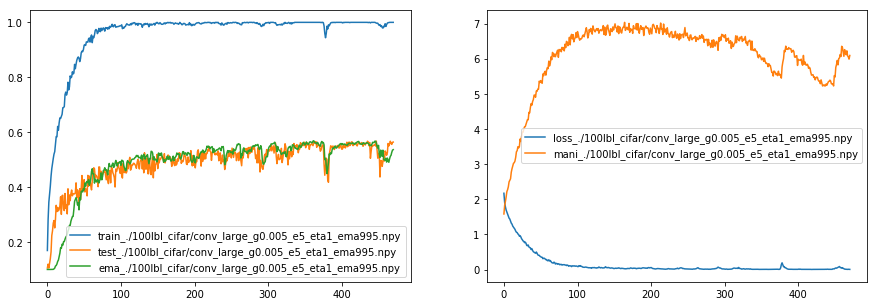

Epoch: 471,global_stp: 9440, xloss: 0.00428, maniloss: 5.97251, train: 100.00%, test: 55.95,test_ma: 54.17%
Epoch: 472,global_stp: 9460, xloss: 0.00463, maniloss: 5.86469, train: 100.00%, test: 56.68,test_ma: 54.74%
Epoch: 473,global_stp: 9480, xloss: 0.00563, maniloss: 5.85258, train: 100.00%, test: 56.82,test_ma: 54.91%
Epoch: 474,global_stp: 9500, xloss: 0.00618, maniloss: 5.80196, train: 100.00%, test: 56.01,test_ma: 55.00%
Epoch: 475,global_stp: 9520, xloss: 0.00474, maniloss: 5.85206, train: 100.00%, test: 56.23,test_ma: 55.71%
Epoch: 476,global_stp: 9540, xloss: 0.00447, maniloss: 5.89321, train: 100.00%, test: 56.79,test_ma: 56.39%
Epoch: 477,global_stp: 9560, xloss: 0.00571, maniloss: 5.79495, train: 100.00%, test: 56.29,test_ma: 56.73%
Epoch: 478,global_stp: 9580, xloss: 0.00437, maniloss: 5.71004, train: 100.00%, test: 56.38,test_ma: 56.83%
Epoch: 479,global_stp: 9600, xloss: 0.00489, maniloss: 5.75777, train: 99.90%, test: 56.65,test_ma: 57.06%
Epoch: 480,global_stp: 9620, 

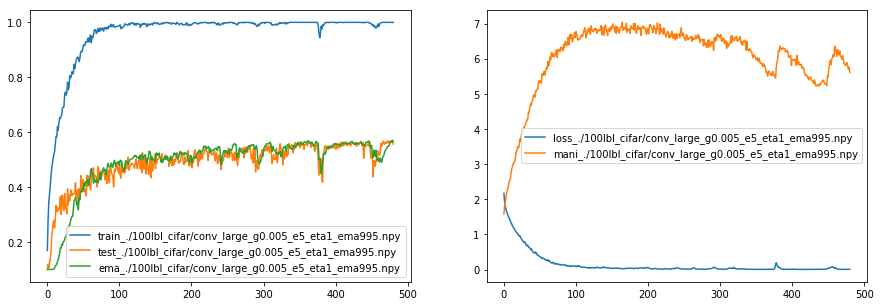

Epoch: 481,global_stp: 9640, xloss: 0.00464, maniloss: 5.62489, train: 100.00%, test: 55.95,test_ma: 56.39%
Epoch: 482,global_stp: 9660, xloss: 0.00653, maniloss: 5.56130, train: 100.00%, test: 56.51,test_ma: 56.61%
Epoch: 483,global_stp: 9680, xloss: 0.00653, maniloss: 5.68534, train: 100.00%, test: 56.49,test_ma: 56.95%
Epoch: 484,global_stp: 9700, xloss: 0.00458, maniloss: 5.49902, train: 100.00%, test: 56.06,test_ma: 56.84%
Epoch: 485,global_stp: 9720, xloss: 0.00444, maniloss: 5.41977, train: 100.00%, test: 57.47,test_ma: 57.11%
Epoch: 486,global_stp: 9740, xloss: 0.00439, maniloss: 5.44848, train: 100.00%, test: 57.05,test_ma: 56.99%
Epoch: 487,global_stp: 9760, xloss: 0.00429, maniloss: 5.42778, train: 100.00%, test: 56.04,test_ma: 56.72%
Epoch: 488,global_stp: 9780, xloss: 0.00457, maniloss: 5.38346, train: 100.00%, test: 56.57,test_ma: 57.17%
Epoch: 489,global_stp: 9800, xloss: 0.00525, maniloss: 5.33291, train: 100.00%, test: 57.24,test_ma: 57.58%
Epoch: 490,global_stp: 9820,

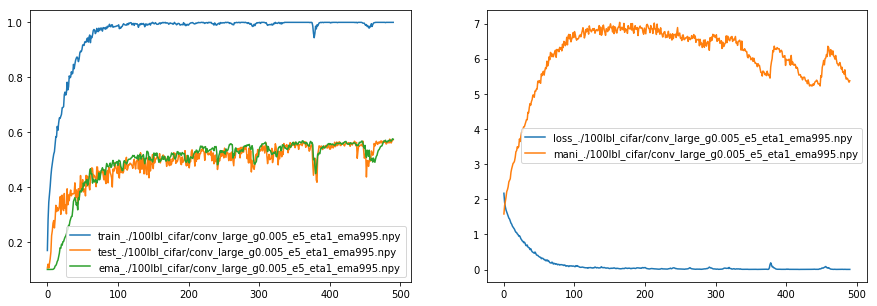

Epoch: 491,global_stp: 9840, xloss: 0.00561, maniloss: 5.28006, train: 100.00%, test: 55.48,test_ma: 57.67%
Epoch: 492,global_stp: 9860, xloss: 0.00389, maniloss: 5.29759, train: 100.00%, test: 56.61,test_ma: 57.86%
Epoch: 493,global_stp: 9880, xloss: 0.00551, maniloss: 5.23647, train: 100.00%, test: 56.37,test_ma: 57.83%
Epoch: 494,global_stp: 9900, xloss: 0.00560, maniloss: 5.39392, train: 100.00%, test: 54.73,test_ma: 57.72%
Epoch: 495,global_stp: 9920, xloss: 0.00658, maniloss: 5.35232, train: 100.00%, test: 57.03,test_ma: 58.19%
Epoch: 496,global_stp: 9940, xloss: 0.00524, maniloss: 5.33597, train: 100.00%, test: 56.77,test_ma: 57.60%
Epoch: 497,global_stp: 9960, xloss: 0.00401, maniloss: 5.29621, train: 100.00%, test: 56.81,test_ma: 57.91%
Epoch: 498,global_stp: 9980, xloss: 0.00467, maniloss: 5.19223, train: 100.00%, test: 57.27,test_ma: 57.73%
Epoch: 499,global_stp: 10000, xloss: 0.00685, maniloss: 5.26799, train: 100.00%, test: 56.15,test_ma: 57.47%
Epoch: 500,global_stp: 1002

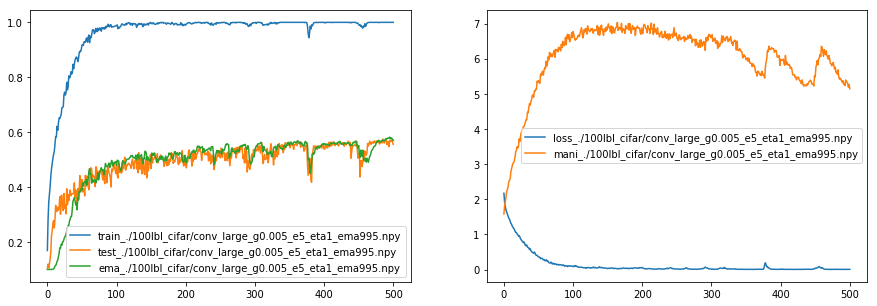

Epoch: 501,global_stp: 10040, xloss: 0.00687, maniloss: 5.20945, train: 100.00%, test: 54.45,test_ma: 57.08%
Epoch: 502,global_stp: 10060, xloss: 0.00414, maniloss: 5.15342, train: 100.00%, test: 55.14,test_ma: 57.08%
Epoch: 503,global_stp: 10080, xloss: 0.00456, maniloss: 5.05530, train: 100.00%, test: 56.77,test_ma: 56.79%
Epoch: 504,global_stp: 10100, xloss: 0.00419, maniloss: 5.09154, train: 100.00%, test: 57.15,test_ma: 57.15%
Epoch: 505,global_stp: 10120, xloss: 0.00553, maniloss: 5.12557, train: 100.00%, test: 57.06,test_ma: 57.65%
Epoch: 506,global_stp: 10140, xloss: 0.00604, maniloss: 5.09110, train: 100.00%, test: 56.96,test_ma: 57.54%
Epoch: 507,global_stp: 10160, xloss: 0.00643, maniloss: 5.01433, train: 100.00%, test: 56.62,test_ma: 56.94%
Epoch: 508,global_stp: 10180, xloss: 0.00405, maniloss: 5.09243, train: 100.00%, test: 57.14,test_ma: 57.09%
Epoch: 509,global_stp: 10200, xloss: 0.00562, maniloss: 5.09056, train: 99.90%, test: 54.38,test_ma: 56.99%
Epoch: 510,global_st

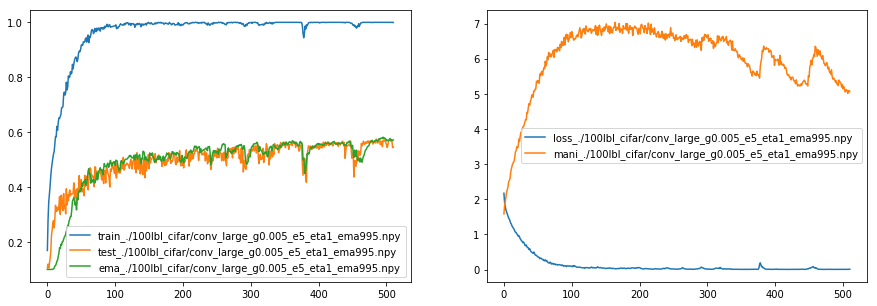

Epoch: 511,global_stp: 10240, xloss: 0.00678, maniloss: 5.06023, train: 100.00%, test: 55.91,test_ma: 57.10%
Epoch: 512,global_stp: 10260, xloss: 0.00495, maniloss: 5.03663, train: 100.00%, test: 55.32,test_ma: 57.95%
Epoch: 513,global_stp: 10280, xloss: 0.00410, maniloss: 5.07473, train: 100.00%, test: 56.84,test_ma: 57.93%
Epoch: 514,global_stp: 10300, xloss: 0.00492, maniloss: 4.92597, train: 100.00%, test: 57.58,test_ma: 57.28%
Epoch: 515,global_stp: 10320, xloss: 0.00452, maniloss: 4.96700, train: 100.00%, test: 55.70,test_ma: 56.30%
Epoch: 516,global_stp: 10340, xloss: 0.00498, maniloss: 4.93652, train: 100.00%, test: 56.11,test_ma: 56.38%
Epoch: 517,global_stp: 10360, xloss: 0.00534, maniloss: 4.94217, train: 100.00%, test: 55.73,test_ma: 56.73%
Epoch: 518,global_stp: 10380, xloss: 0.00443, maniloss: 4.96197, train: 100.00%, test: 56.24,test_ma: 57.10%
Epoch: 519,global_stp: 10400, xloss: 0.00516, maniloss: 4.85407, train: 100.00%, test: 57.09,test_ma: 57.00%
Epoch: 520,global_s

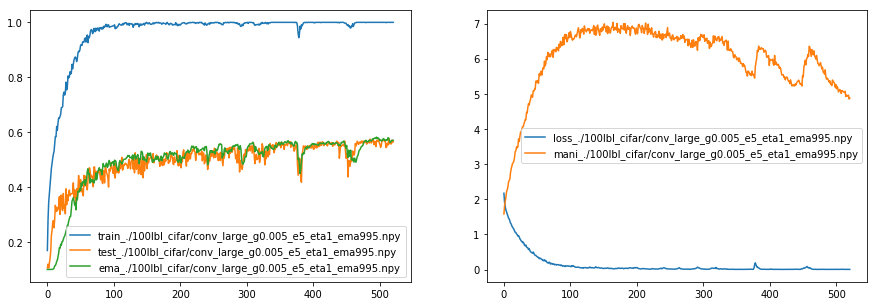

Epoch: 521,global_stp: 10440, xloss: 0.00472, maniloss: 4.89829, train: 100.00%, test: 57.56,test_ma: 57.09%
Epoch: 522,global_stp: 10460, xloss: 0.00456, maniloss: 4.87525, train: 100.00%, test: 56.85,test_ma: 56.80%
Epoch: 523,global_stp: 10480, xloss: 0.00524, maniloss: 4.78730, train: 100.00%, test: 55.76,test_ma: 56.65%
Epoch: 524,global_stp: 10500, xloss: 0.00646, maniloss: 4.88270, train: 100.00%, test: 56.24,test_ma: 56.78%
Epoch: 525,global_stp: 10520, xloss: 0.00607, maniloss: 4.90223, train: 100.00%, test: 56.55,test_ma: 56.59%
Epoch: 526,global_stp: 10540, xloss: 0.00626, maniloss: 4.89676, train: 100.00%, test: 56.34,test_ma: 56.83%
Epoch: 527,global_stp: 10560, xloss: 0.00609, maniloss: 4.83898, train: 100.00%, test: 56.26,test_ma: 56.90%
Epoch: 528,global_stp: 10580, xloss: 0.00672, maniloss: 4.95231, train: 99.90%, test: 56.39,test_ma: 56.65%
Epoch: 529,global_stp: 10600, xloss: 0.00757, maniloss: 4.91497, train: 99.90%, test: 55.28,test_ma: 57.10%
Epoch: 530,global_stp

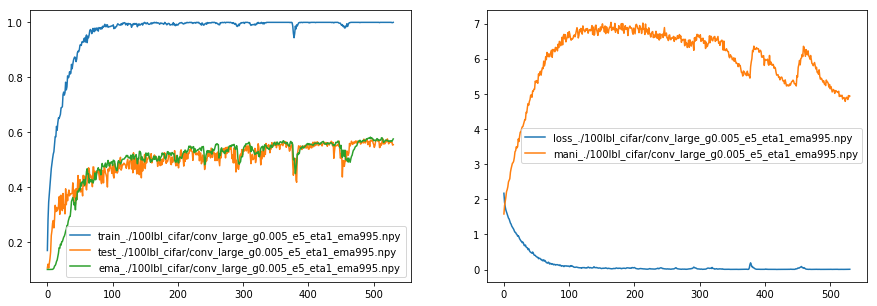

Epoch: 531,global_stp: 10640, xloss: 0.01109, maniloss: 5.04296, train: 99.90%, test: 54.85,test_ma: 57.46%
Epoch: 532,global_stp: 10660, xloss: 0.00694, maniloss: 4.95089, train: 100.00%, test: 54.79,test_ma: 58.18%
Epoch: 533,global_stp: 10680, xloss: 0.00684, maniloss: 4.88349, train: 100.00%, test: 55.84,test_ma: 58.69%
Epoch: 534,global_stp: 10700, xloss: 0.00572, maniloss: 5.03510, train: 100.00%, test: 56.82,test_ma: 58.45%
Epoch: 535,global_stp: 10720, xloss: 0.00767, maniloss: 4.92999, train: 99.90%, test: 56.85,test_ma: 58.23%
Epoch: 536,global_stp: 10740, xloss: 0.00570, maniloss: 5.10464, train: 100.00%, test: 55.65,test_ma: 57.96%
Epoch: 537,global_stp: 10760, xloss: 0.00458, maniloss: 4.96869, train: 100.00%, test: 57.35,test_ma: 57.45%
Epoch: 538,global_stp: 10780, xloss: 0.00539, maniloss: 4.99897, train: 100.00%, test: 55.68,test_ma: 57.39%
Epoch: 539,global_stp: 10800, xloss: 0.00403, maniloss: 4.90470, train: 100.00%, test: 57.19,test_ma: 57.46%
Epoch: 540,global_stp

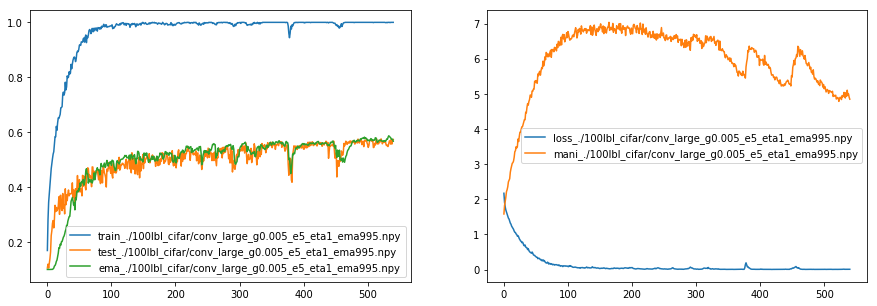

Epoch: 541,global_stp: 10840, xloss: 0.00774, maniloss: 4.88542, train: 100.00%, test: 55.55,test_ma: 56.33%
Epoch: 542,global_stp: 10860, xloss: 0.00660, maniloss: 4.93158, train: 100.00%, test: 55.18,test_ma: 56.90%
Epoch: 543,global_stp: 10880, xloss: 0.00568, maniloss: 4.78430, train: 100.00%, test: 55.40,test_ma: 56.64%
Epoch: 544,global_stp: 10900, xloss: 0.00585, maniloss: 5.04612, train: 100.00%, test: 56.70,test_ma: 56.85%
Epoch: 545,global_stp: 10920, xloss: 0.00668, maniloss: 4.97253, train: 100.00%, test: 55.00,test_ma: 56.83%
Epoch: 546,global_stp: 10940, xloss: 0.00692, maniloss: 4.98647, train: 100.00%, test: 55.50,test_ma: 57.60%
Epoch: 547,global_stp: 10960, xloss: 0.00724, maniloss: 4.90975, train: 99.90%, test: 55.10,test_ma: 57.52%
Epoch: 548,global_stp: 10980, xloss: 0.02918, maniloss: 5.00275, train: 99.30%, test: 53.30,test_ma: 58.05%
Epoch: 549,global_stp: 11000, xloss: 0.05569, maniloss: 5.21321, train: 98.60%, test: 51.05,test_ma: 56.42%
Epoch: 550,global_stp:

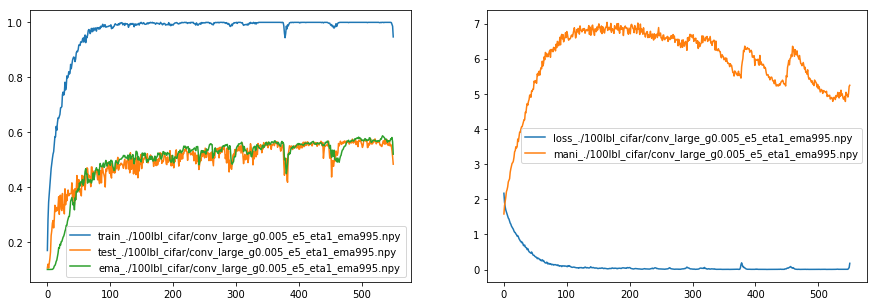

Epoch: 551,global_stp: 11040, xloss: 0.15581, maniloss: 5.64559, train: 95.40%, test: 51.06,test_ma: 49.09%
Epoch: 552,global_stp: 11060, xloss: 0.05972, maniloss: 5.91653, train: 98.70%, test: 50.17,test_ma: 47.26%
Epoch: 553,global_stp: 11080, xloss: 0.07385, maniloss: 6.00279, train: 98.00%, test: 49.71,test_ma: 48.87%
Epoch: 554,global_stp: 11100, xloss: 0.05398, maniloss: 5.80918, train: 98.60%, test: 48.12,test_ma: 50.01%
Epoch: 555,global_stp: 11120, xloss: 0.02894, maniloss: 6.03982, train: 99.40%, test: 50.47,test_ma: 50.55%
Epoch: 556,global_stp: 11140, xloss: 0.01545, maniloss: 5.88693, train: 99.90%, test: 55.51,test_ma: 51.54%
Epoch: 557,global_stp: 11160, xloss: 0.00913, maniloss: 5.87285, train: 99.90%, test: 54.52,test_ma: 50.84%
Epoch: 558,global_stp: 11180, xloss: 0.00854, maniloss: 5.92982, train: 100.00%, test: 54.88,test_ma: 52.22%
Epoch: 559,global_stp: 11200, xloss: 0.01090, maniloss: 5.97129, train: 99.90%, test: 54.75,test_ma: 53.81%
Epoch: 560,global_stp: 1122

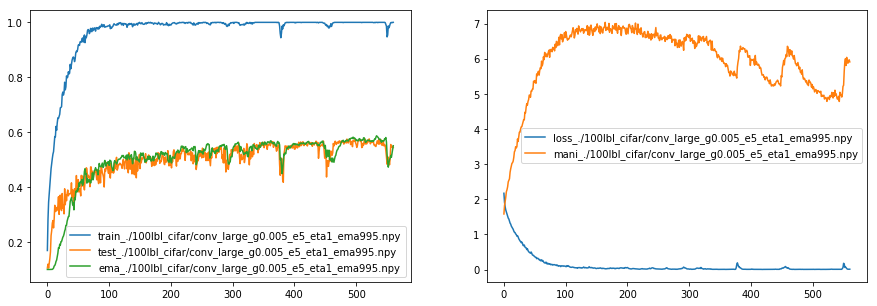

Epoch: 561,global_stp: 11240, xloss: 0.00691, maniloss: 5.88083, train: 100.00%, test: 55.06,test_ma: 55.13%
Epoch: 562,global_stp: 11260, xloss: 0.00650, maniloss: 5.77575, train: 100.00%, test: 56.13,test_ma: 55.38%
Epoch: 563,global_stp: 11280, xloss: 0.00595, maniloss: 5.86812, train: 100.00%, test: 56.62,test_ma: 55.75%
Epoch: 564,global_stp: 11300, xloss: 0.00497, maniloss: 5.64511, train: 100.00%, test: 56.36,test_ma: 55.92%
Epoch: 565,global_stp: 11320, xloss: 0.00433, maniloss: 5.64482, train: 100.00%, test: 56.99,test_ma: 56.35%
Epoch: 566,global_stp: 11340, xloss: 0.00375, maniloss: 5.57035, train: 100.00%, test: 57.50,test_ma: 56.65%
Epoch: 567,global_stp: 11360, xloss: 0.00403, maniloss: 5.61184, train: 100.00%, test: 57.31,test_ma: 56.23%
Epoch: 568,global_stp: 11380, xloss: 0.00409, maniloss: 5.53397, train: 100.00%, test: 56.93,test_ma: 56.37%
Epoch: 569,global_stp: 11400, xloss: 0.00386, maniloss: 5.40298, train: 100.00%, test: 57.15,test_ma: 56.64%
Epoch: 570,global_s

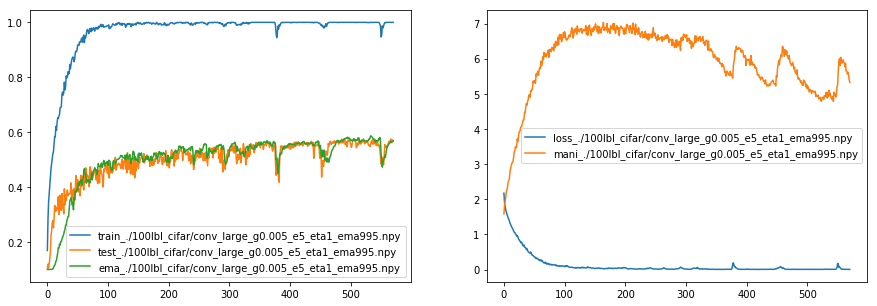

Epoch: 571,global_stp: 11440, xloss: 0.00335, maniloss: 5.27890, train: 100.00%, test: 56.28,test_ma: 56.79%
Epoch: 572,global_stp: 11460, xloss: 0.00391, maniloss: 5.27824, train: 100.00%, test: 56.71,test_ma: 56.89%
Epoch: 573,global_stp: 11480, xloss: 0.00390, maniloss: 5.19995, train: 100.00%, test: 56.39,test_ma: 56.86%
Epoch: 574,global_stp: 11500, xloss: 0.00470, maniloss: 5.13510, train: 100.00%, test: 56.62,test_ma: 56.71%
Epoch: 575,global_stp: 11520, xloss: 0.00416, maniloss: 5.19654, train: 100.00%, test: 56.61,test_ma: 56.90%
Epoch: 576,global_stp: 11540, xloss: 0.00382, maniloss: 5.02621, train: 100.00%, test: 56.70,test_ma: 57.03%
Epoch: 577,global_stp: 11560, xloss: 0.00363, maniloss: 4.97274, train: 100.00%, test: 56.51,test_ma: 56.93%
Epoch: 578,global_stp: 11580, xloss: 0.00380, maniloss: 5.14336, train: 100.00%, test: 57.08,test_ma: 57.07%
Epoch: 579,global_stp: 11600, xloss: 0.00424, maniloss: 4.96204, train: 100.00%, test: 56.69,test_ma: 56.97%
Epoch: 580,global_s

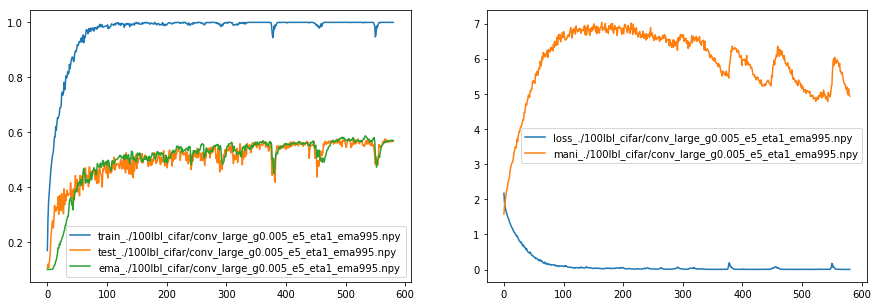

Epoch: 581,global_stp: 11640, xloss: 0.00461, maniloss: 4.88216, train: 100.00%, test: 56.20,test_ma: 56.97%
Epoch: 582,global_stp: 11660, xloss: 0.00422, maniloss: 4.91190, train: 100.00%, test: 56.37,test_ma: 56.86%
Epoch: 583,global_stp: 11680, xloss: 0.00497, maniloss: 4.95117, train: 100.00%, test: 56.28,test_ma: 57.02%
Epoch: 584,global_stp: 11700, xloss: 0.00519, maniloss: 4.77776, train: 100.00%, test: 56.78,test_ma: 57.13%
Epoch: 585,global_stp: 11720, xloss: 0.00569, maniloss: 4.91745, train: 100.00%, test: 56.88,test_ma: 56.97%
Epoch: 586,global_stp: 11740, xloss: 0.00460, maniloss: 4.98898, train: 100.00%, test: 56.73,test_ma: 56.77%
Epoch: 587,global_stp: 11760, xloss: 0.00633, maniloss: 4.85239, train: 99.90%, test: 56.40,test_ma: 56.69%
Epoch: 588,global_stp: 11780, xloss: 0.00494, maniloss: 4.87011, train: 100.00%, test: 56.97,test_ma: 56.87%
Epoch: 589,global_stp: 11800, xloss: 0.00466, maniloss: 4.84858, train: 100.00%, test: 56.94,test_ma: 56.73%
Epoch: 590,global_st

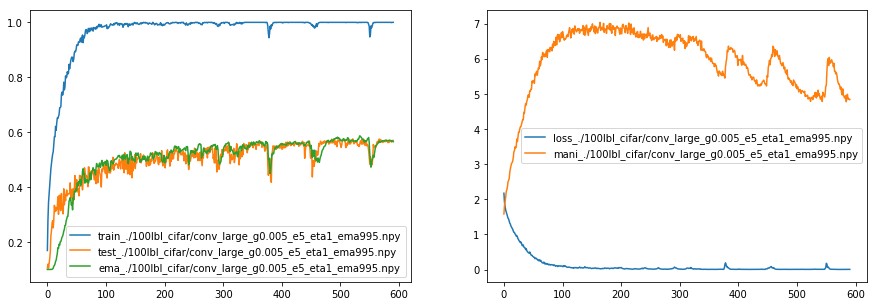

Epoch: 591,global_stp: 11840, xloss: 0.00637, maniloss: 4.74572, train: 99.90%, test: 56.13,test_ma: 56.66%
Epoch: 592,global_stp: 11860, xloss: 0.00516, maniloss: 4.86208, train: 100.00%, test: 55.52,test_ma: 56.86%
Epoch: 593,global_stp: 11880, xloss: 0.00357, maniloss: 4.75007, train: 100.00%, test: 56.24,test_ma: 57.25%
Epoch: 594,global_stp: 11900, xloss: 0.00432, maniloss: 4.79680, train: 100.00%, test: 57.04,test_ma: 56.85%
Epoch: 595,global_stp: 11920, xloss: 0.00496, maniloss: 4.81798, train: 100.00%, test: 54.67,test_ma: 56.87%
Epoch: 596,global_stp: 11940, xloss: 0.01189, maniloss: 4.69557, train: 99.80%, test: 54.79,test_ma: 57.06%
Epoch: 597,global_stp: 11960, xloss: 0.00798, maniloss: 4.80435, train: 100.00%, test: 54.53,test_ma: 57.56%
Epoch: 598,global_stp: 11980, xloss: 0.00526, maniloss: 4.89773, train: 100.00%, test: 56.35,test_ma: 57.77%
Epoch: 599,global_stp: 12000, xloss: 0.00555, maniloss: 4.84816, train: 100.00%, test: 56.93,test_ma: 57.84%
Epoch: 600,global_stp

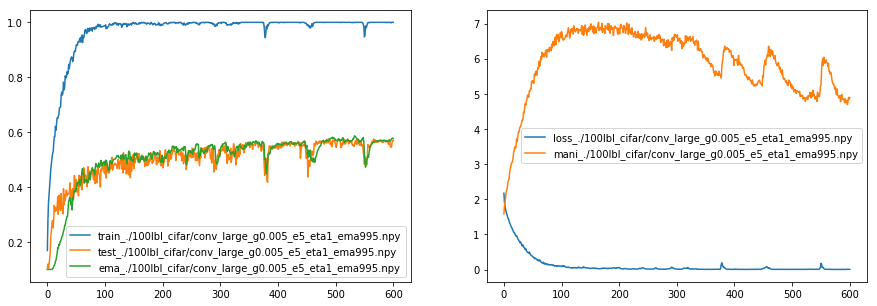

Epoch: 601,global_stp: 12040, xloss: 0.00438, maniloss: 4.74512, train: 100.00%, test: 56.56,test_ma: 57.53%
Epoch: 602,global_stp: 12060, xloss: 0.00415, maniloss: 4.81417, train: 100.00%, test: 56.62,test_ma: 57.87%
Epoch: 603,global_stp: 12080, xloss: 0.00441, maniloss: 4.63020, train: 100.00%, test: 57.14,test_ma: 57.33%
Epoch: 604,global_stp: 12100, xloss: 0.00354, maniloss: 4.75905, train: 100.00%, test: 57.22,test_ma: 57.40%
Epoch: 605,global_stp: 12120, xloss: 0.00345, maniloss: 4.57668, train: 100.00%, test: 56.77,test_ma: 57.56%
Epoch: 606,global_stp: 12140, xloss: 0.00375, maniloss: 4.54773, train: 100.00%, test: 56.61,test_ma: 57.74%
Epoch: 607,global_stp: 12160, xloss: 0.00437, maniloss: 4.59066, train: 100.00%, test: 56.65,test_ma: 57.43%
Epoch: 608,global_stp: 12180, xloss: 0.00519, maniloss: 4.55140, train: 100.00%, test: 56.45,test_ma: 57.35%
Epoch: 609,global_stp: 12200, xloss: 0.00626, maniloss: 4.66726, train: 100.00%, test: 56.44,test_ma: 57.61%
Epoch: 610,global_s

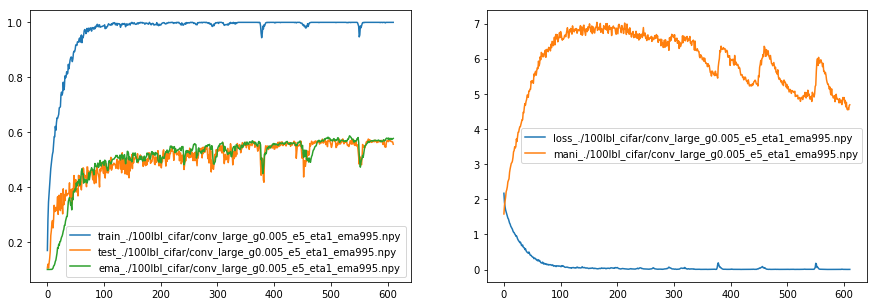

Epoch: 611,global_stp: 12240, xloss: 0.00590, maniloss: 4.61713, train: 100.00%, test: 57.89,test_ma: 57.16%
Epoch: 612,global_stp: 12260, xloss: 0.00442, maniloss: 4.59091, train: 100.00%, test: 56.73,test_ma: 56.37%
Epoch: 613,global_stp: 12280, xloss: 0.00518, maniloss: 4.66875, train: 100.00%, test: 55.50,test_ma: 56.30%
Epoch: 614,global_stp: 12300, xloss: 0.00434, maniloss: 4.62382, train: 100.00%, test: 55.83,test_ma: 56.22%
Epoch: 615,global_stp: 12320, xloss: 0.00395, maniloss: 4.58355, train: 100.00%, test: 56.84,test_ma: 56.74%
Epoch: 616,global_stp: 12340, xloss: 0.00384, maniloss: 4.37200, train: 100.00%, test: 57.21,test_ma: 56.70%
Epoch: 617,global_stp: 12360, xloss: 0.00473, maniloss: 4.51790, train: 100.00%, test: 56.91,test_ma: 56.87%
Epoch: 618,global_stp: 12380, xloss: 0.00437, maniloss: 4.42594, train: 100.00%, test: 57.33,test_ma: 56.90%
Epoch: 619,global_stp: 12400, xloss: 0.00485, maniloss: 4.48715, train: 100.00%, test: 57.02,test_ma: 57.04%
Epoch: 620,global_s

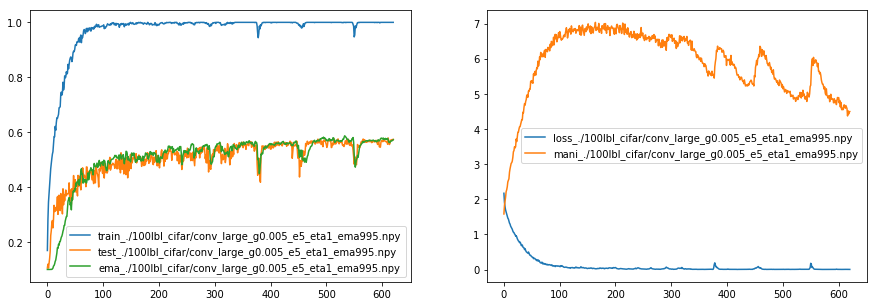

Epoch: 621,global_stp: 12440, xloss: 0.00431, maniloss: 4.39794, train: 100.00%, test: 57.06,test_ma: 57.15%
Epoch: 622,global_stp: 12460, xloss: 0.00345, maniloss: 4.51834, train: 100.00%, test: 56.30,test_ma: 57.24%
Epoch: 623,global_stp: 12480, xloss: 0.00427, maniloss: 4.35949, train: 100.00%, test: 56.98,test_ma: 57.08%
Epoch: 624,global_stp: 12500, xloss: 0.00384, maniloss: 4.41329, train: 100.00%, test: 57.28,test_ma: 56.97%
Epoch: 625,global_stp: 12520, xloss: 0.00361, maniloss: 4.29524, train: 100.00%, test: 56.97,test_ma: 56.49%
Epoch: 626,global_stp: 12540, xloss: 0.00440, maniloss: 4.29728, train: 100.00%, test: 57.48,test_ma: 56.89%
Epoch: 627,global_stp: 12560, xloss: 0.00454, maniloss: 4.38433, train: 100.00%, test: 56.38,test_ma: 56.75%
Epoch: 628,global_stp: 12580, xloss: 0.00384, maniloss: 4.38261, train: 100.00%, test: 56.61,test_ma: 57.07%
Epoch: 629,global_stp: 12600, xloss: 0.00500, maniloss: 4.33167, train: 100.00%, test: 57.17,test_ma: 57.31%
Epoch: 630,global_s

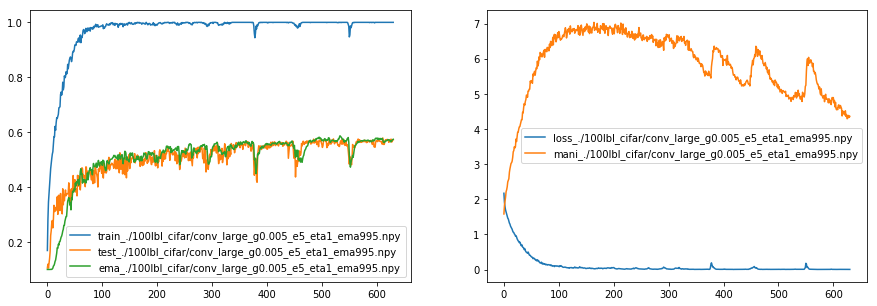

Epoch: 631,global_stp: 12640, xloss: 0.00418, maniloss: 4.38418, train: 100.00%, test: 56.70,test_ma: 57.14%
Epoch: 632,global_stp: 12660, xloss: 0.00413, maniloss: 4.32515, train: 100.00%, test: 55.91,test_ma: 57.32%
Epoch: 633,global_stp: 12680, xloss: 0.00642, maniloss: 4.36970, train: 100.00%, test: 57.08,test_ma: 57.88%
Epoch: 634,global_stp: 12700, xloss: 0.00454, maniloss: 4.40842, train: 100.00%, test: 56.80,test_ma: 57.25%
Epoch: 635,global_stp: 12720, xloss: 0.00433, maniloss: 4.43731, train: 100.00%, test: 56.88,test_ma: 56.88%
Epoch: 636,global_stp: 12740, xloss: 0.00644, maniloss: 4.40552, train: 100.00%, test: 57.27,test_ma: 57.06%
Epoch: 637,global_stp: 12760, xloss: 0.00373, maniloss: 4.52029, train: 100.00%, test: 57.42,test_ma: 56.61%
Epoch: 638,global_stp: 12780, xloss: 0.00322, maniloss: 4.28273, train: 100.00%, test: 57.00,test_ma: 56.82%
Epoch: 639,global_stp: 12800, xloss: 0.00426, maniloss: 4.30357, train: 100.00%, test: 56.64,test_ma: 56.73%
Epoch: 640,global_s

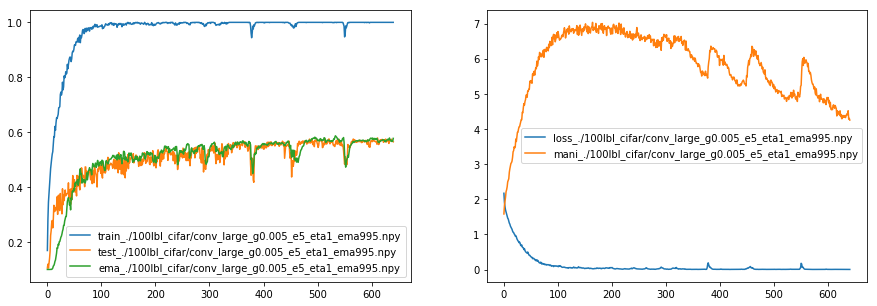

Epoch: 641,global_stp: 12840, xloss: 0.00436, maniloss: 4.23004, train: 100.00%, test: 57.62,test_ma: 58.06%
Epoch: 642,global_stp: 12860, xloss: 0.00379, maniloss: 4.27402, train: 100.00%, test: 57.39,test_ma: 57.67%
Epoch: 643,global_stp: 12880, xloss: 0.00367, maniloss: 4.20939, train: 100.00%, test: 57.22,test_ma: 57.27%
Epoch: 644,global_stp: 12900, xloss: 0.00402, maniloss: 4.17015, train: 100.00%, test: 56.99,test_ma: 57.38%
Epoch: 645,global_stp: 12920, xloss: 0.00413, maniloss: 4.24681, train: 100.00%, test: 56.97,test_ma: 57.48%
Epoch: 646,global_stp: 12940, xloss: 0.00308, maniloss: 4.12198, train: 100.00%, test: 56.80,test_ma: 57.19%
Epoch: 647,global_stp: 12960, xloss: 0.00354, maniloss: 4.09891, train: 100.00%, test: 57.19,test_ma: 57.31%
Epoch: 648,global_stp: 12980, xloss: 0.00510, maniloss: 4.09244, train: 100.00%, test: 57.43,test_ma: 57.66%
Epoch: 649,global_stp: 13000, xloss: 0.00349, maniloss: 4.15639, train: 100.00%, test: 57.20,test_ma: 57.41%
Epoch: 650,global_s

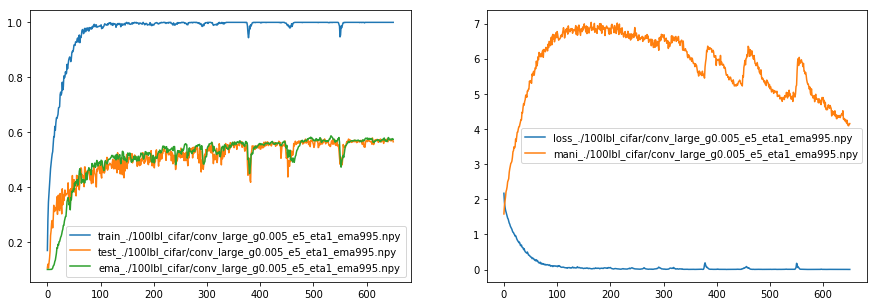

Epoch: 651,global_stp: 13040, xloss: 0.00464, maniloss: 4.14870, train: 100.00%, test: 56.44,test_ma: 57.53%
Epoch: 652,global_stp: 13060, xloss: 0.00395, maniloss: 4.08862, train: 100.00%, test: 56.50,test_ma: 57.63%
Epoch: 653,global_stp: 13080, xloss: 0.00408, maniloss: 4.14780, train: 100.00%, test: 57.51,test_ma: 58.03%
Epoch: 654,global_stp: 13100, xloss: 0.00377, maniloss: 4.05442, train: 100.00%, test: 57.64,test_ma: 57.37%
Epoch: 655,global_stp: 13120, xloss: 0.00437, maniloss: 4.06392, train: 100.00%, test: 57.30,test_ma: 57.71%
Epoch: 656,global_stp: 13140, xloss: 0.00387, maniloss: 4.03948, train: 100.00%, test: 57.58,test_ma: 57.63%
Epoch: 657,global_stp: 13160, xloss: 0.00334, maniloss: 4.11524, train: 100.00%, test: 56.97,test_ma: 57.67%
Epoch: 658,global_stp: 13180, xloss: 0.00435, maniloss: 4.08899, train: 100.00%, test: 57.42,test_ma: 57.33%
Epoch: 659,global_stp: 13200, xloss: 0.00395, maniloss: 4.08858, train: 100.00%, test: 57.59,test_ma: 57.56%
Epoch: 660,global_s

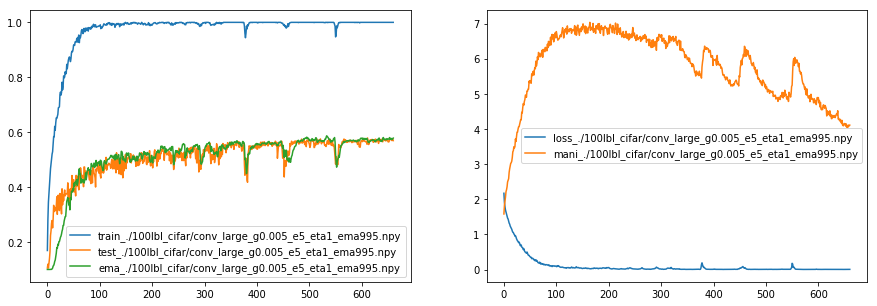

Epoch: 661,global_stp: 13240, xloss: 0.00438, maniloss: 4.12912, train: 99.90%, test: 56.61,test_ma: 57.78%
Epoch: 662,global_stp: 13260, xloss: 0.00568, maniloss: 4.14883, train: 100.00%, test: 57.04,test_ma: 57.75%
Epoch: 663,global_stp: 13280, xloss: 0.00463, maniloss: 4.11039, train: 100.00%, test: 57.02,test_ma: 57.56%
Epoch: 664,global_stp: 13300, xloss: 0.00505, maniloss: 4.20400, train: 100.00%, test: 56.34,test_ma: 57.52%
Epoch: 665,global_stp: 13320, xloss: 0.01852, maniloss: 4.26381, train: 99.70%, test: 57.50,test_ma: 56.41%
Epoch: 666,global_stp: 13340, xloss: 0.04564, maniloss: 4.33179, train: 98.90%, test: 53.30,test_ma: 52.04%
Epoch: 667,global_stp: 13360, xloss: 0.12238, maniloss: 4.92015, train: 97.00%, test: 45.38,test_ma: 50.03%
Epoch: 668,global_stp: 13380, xloss: 0.19453, maniloss: 5.22916, train: 93.60%, test: 43.76,test_ma: 48.95%
Epoch: 669,global_stp: 13400, xloss: 0.17070, maniloss: 5.39093, train: 95.00%, test: 38.03,test_ma: 44.79%
Epoch: 670,global_stp: 13

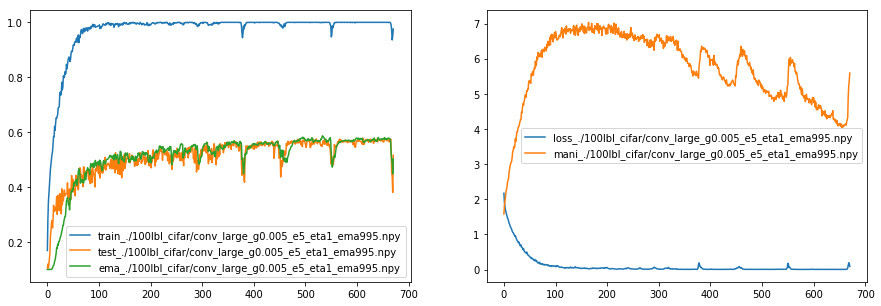

Epoch: 671,global_stp: 13440, xloss: 0.05747, maniloss: 5.77654, train: 98.60%, test: 50.63,test_ma: 48.91%
Epoch: 672,global_stp: 13460, xloss: 0.03504, maniloss: 5.93019, train: 99.30%, test: 54.76,test_ma: 48.91%
Epoch: 673,global_stp: 13480, xloss: 0.01697, maniloss: 5.91827, train: 99.90%, test: 55.89,test_ma: 51.42%
Epoch: 674,global_stp: 13500, xloss: 0.01130, maniloss: 5.80927, train: 99.90%, test: 56.83,test_ma: 52.27%
Epoch: 675,global_stp: 13520, xloss: 0.00996, maniloss: 5.78820, train: 99.90%, test: 56.95,test_ma: 52.96%
Epoch: 676,global_stp: 13540, xloss: 0.01276, maniloss: 5.75770, train: 99.60%, test: 54.18,test_ma: 55.02%
Epoch: 677,global_stp: 13560, xloss: 0.01158, maniloss: 5.65073, train: 99.90%, test: 56.74,test_ma: 55.52%
Epoch: 678,global_stp: 13580, xloss: 0.01102, maniloss: 5.59811, train: 99.90%, test: 57.25,test_ma: 55.53%
Epoch: 679,global_stp: 13600, xloss: 0.01292, maniloss: 5.54612, train: 99.80%, test: 56.17,test_ma: 54.84%
Epoch: 680,global_stp: 13620

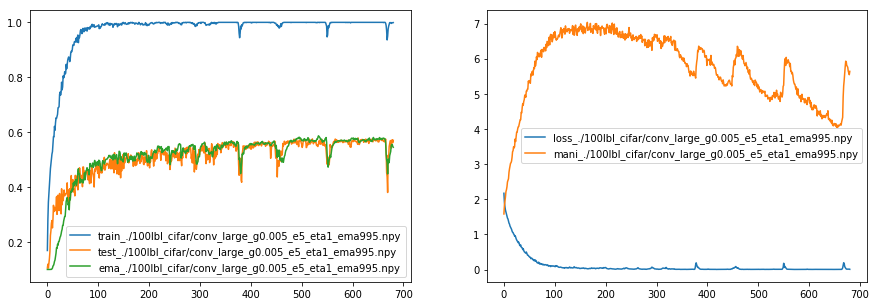

Epoch: 681,global_stp: 13640, xloss: 0.00794, maniloss: 5.44361, train: 99.90%, test: 56.37,test_ma: 54.32%
Epoch: 682,global_stp: 13660, xloss: 0.00512, maniloss: 5.48808, train: 100.00%, test: 56.18,test_ma: 55.57%
Epoch: 683,global_stp: 13680, xloss: 0.00380, maniloss: 5.50709, train: 100.00%, test: 57.16,test_ma: 56.74%
Epoch: 684,global_stp: 13700, xloss: 0.00367, maniloss: 5.35885, train: 100.00%, test: 57.66,test_ma: 56.62%
Epoch: 685,global_stp: 13720, xloss: 0.00385, maniloss: 5.16850, train: 100.00%, test: 57.33,test_ma: 56.81%
Epoch: 686,global_stp: 13740, xloss: 0.00351, maniloss: 5.10599, train: 100.00%, test: 57.07,test_ma: 56.86%
Epoch: 687,global_stp: 13760, xloss: 0.00396, maniloss: 5.07433, train: 100.00%, test: 57.33,test_ma: 56.89%
Epoch: 688,global_stp: 13780, xloss: 0.00432, maniloss: 5.05201, train: 100.00%, test: 56.99,test_ma: 56.97%
Epoch: 689,global_stp: 13800, xloss: 0.00375, maniloss: 4.87449, train: 100.00%, test: 57.59,test_ma: 57.04%
Epoch: 690,global_st

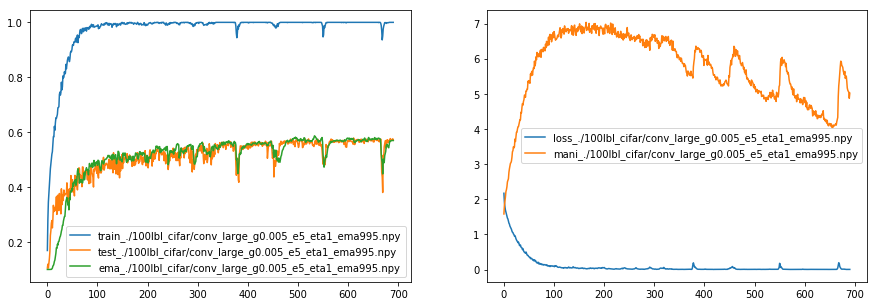

Epoch: 691,global_stp: 13840, xloss: 0.00406, maniloss: 4.92957, train: 100.00%, test: 57.23,test_ma: 57.10%
Epoch: 692,global_stp: 13860, xloss: 0.00473, maniloss: 4.79364, train: 100.00%, test: 57.53,test_ma: 57.43%
Epoch: 693,global_stp: 13880, xloss: 0.00384, maniloss: 4.82405, train: 100.00%, test: 58.01,test_ma: 57.59%
Epoch: 694,global_stp: 13900, xloss: 0.00391, maniloss: 4.77013, train: 100.00%, test: 58.18,test_ma: 57.80%
Epoch: 695,global_stp: 13920, xloss: 0.00447, maniloss: 4.62304, train: 100.00%, test: 58.30,test_ma: 57.61%
Epoch: 696,global_stp: 13940, xloss: 0.00467, maniloss: 4.63890, train: 100.00%, test: 57.65,test_ma: 57.81%
Epoch: 697,global_stp: 13960, xloss: 0.00426, maniloss: 4.66846, train: 100.00%, test: 57.91,test_ma: 57.87%
Epoch: 698,global_stp: 13980, xloss: 0.00500, maniloss: 4.56674, train: 100.00%, test: 57.72,test_ma: 57.90%
Epoch: 699,global_stp: 14000, xloss: 0.00499, maniloss: 4.50027, train: 100.00%, test: 57.54,test_ma: 58.09%
Epoch: 700,global_s

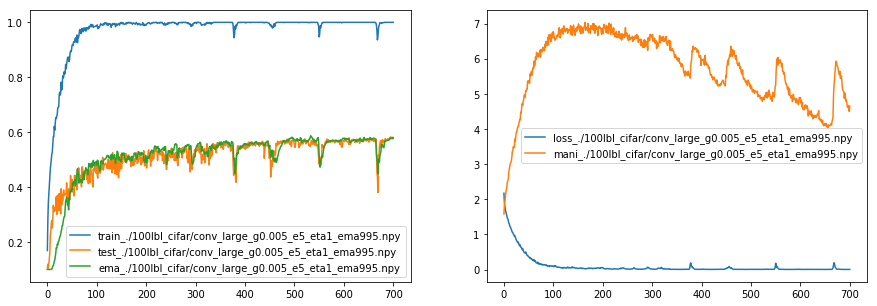

Epoch: 701,global_stp: 14040, xloss: 0.00405, maniloss: 4.54097, train: 100.00%, test: 58.00,test_ma: 57.75%
Epoch: 702,global_stp: 14060, xloss: 0.00402, maniloss: 4.61203, train: 100.00%, test: 57.66,test_ma: 57.67%
Epoch: 703,global_stp: 14080, xloss: 0.00401, maniloss: 4.47624, train: 100.00%, test: 57.18,test_ma: 57.99%
Epoch: 704,global_stp: 14100, xloss: 0.00353, maniloss: 4.39518, train: 100.00%, test: 57.78,test_ma: 58.21%
Epoch: 705,global_stp: 14120, xloss: 0.00408, maniloss: 4.41197, train: 100.00%, test: 58.22,test_ma: 58.12%
Epoch: 706,global_stp: 14140, xloss: 0.00496, maniloss: 4.36540, train: 100.00%, test: 57.15,test_ma: 57.91%
Epoch: 707,global_stp: 14160, xloss: 0.00587, maniloss: 4.30879, train: 100.00%, test: 57.26,test_ma: 57.79%
Epoch: 708,global_stp: 14180, xloss: 0.00419, maniloss: 4.41317, train: 100.00%, test: 57.95,test_ma: 58.14%
Epoch: 709,global_stp: 14200, xloss: 0.00400, maniloss: 4.46073, train: 100.00%, test: 58.11,test_ma: 58.11%


In [ ]:
for epoch in tqdm(range(params_dnn['epoch'])):
    inds = rng.permutation(trainx.shape[0])
    trainx = trainx[inds]
    trainy = trainy[inds]
    train_acc=test_acc=train_loss=train_manifold=test_acc_ema=0
    
    for step in range(nr_batch_train):
        ran_from = step * params_dnn['batch']
        ran_to = (step+1) * params_dnn['batch']
        xl, _ , acc,ml =  sess.run([xloss,train_op, accuracy,manifold_loss], {inp: trainx[ran_from:ran_to],
                                                                             lbl: trainy[ran_from:ran_to],
                                                                             is_training_pl:False,
                                                                             training_cnn:True})
        train_acc += acc; train_loss += xl; train_manifold += ml
    train_acc /= nr_batch_train; train_loss /= nr_batch_train; train_manifold /= nr_batch_train
    train_array.append(train_acc);loss_array.append(train_loss);manifold_array.append(train_manifold)
    for step in range(nr_batch_test):
        ran_from = step * params_dnn['batch']
        ran_to = (step+1) * params_dnn['batch']
        acc,acc_ema = sess.run([accuracy,accuracy_ema], {inp: testx[ran_from:ran_to],
                                         lbl: testy[ran_from:ran_to],
                                         training_cnn:False})
        test_acc += acc; test_acc_ema += acc_ema
    test_acc /= nr_batch_test; test_acc_ema /=nr_batch_test
    test_array.append(test_acc);test_array_ema.append(test_acc_ema)
    
    print("Epoch: {},global_stp: {}, xloss: {:.5f}, maniloss: {:.5f}, train: {:.2f}%, test: {:.2f},test_ma: {:.2f}%".format(
            epoch, sess.run(global_step),train_loss, train_manifold,train_acc * 100,test_acc*100, test_acc_ema*100))
    
    if  (epoch % 10 == 0):
        np.save(name_experiment,{'train': train_array,
        'test' : test_array,
        'ema' : test_array_ema,
        'loss' : loss_array,
        'mani' : manifold_array,
        'name':name_experiment})
        
        plot_dics([np.load(name_experiment)])
        plt.show()

In [ ]:
ls